Similar to notebook [088] but using a single generator and compact syntax.

# Imports and Initialization

## Imports

In [1]:
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *
import pickle
#import h5netcdf
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Initialization

In [2]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}

In [3]:
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']

In [4]:
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']

In [5]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [6]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [7]:
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

In [8]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Data Generators

## First, define generators necessary for rescaling

In [9]:
def train_gen_rescaling(input_rescaling):
    return DataGeneratorCI(
        data_fn = path_array['cold'][0],
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [10]:
train_gen_RH = train_gen_rescaling(in_vars)
train_gen_BMSE = train_gen_rescaling(in_vars)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars)

## And generators only taking a subset of the data

### Implementation

In [11]:
class DataGeneratorCI_Small_Data(DataGenerator):
    def __init__(self, batch_list, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
             Qscaling=None,
             Tscaling=None,
             LHFscaling=None,
             SHFscaling=None,
             output_scaling=False,
             interpolate=False,
             hyam=None,hybm=None,
             inp_sub_Qscaling=None,inp_div_Qscaling=None,
             inp_sub_Tscaling=None,inp_div_Tscaling=None,
             inp_sub_LHFscaling=None,inp_div_LHFscaling=None,
             inp_sub_SHFscaling=None,inp_div_SHFscaling=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,epsQ=1e-3,epsT=1,
                 mode='train'):
        self.output_scaling = output_scaling
        self.interpolate = interpolate
        self.Qscaling = Qscaling
        self.Tscaling = Tscaling
        self.LHFscaling = LHFscaling
        self.SHFscaling = SHFscaling
        self.inp_shape = 64
        self.mode=mode
        self.batch_list = batch_list
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        # Overwrite number of samples and number of batches
        self.n_samples = len(batch_list)*self.batch_size
        self.n_batches = int(np.floor(self.n_samples) / self.batch_size)
        ###################################################
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if Qscaling=='RH':
            self.QLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        elif Qscaling=='QSATdeficit':
            self.QLayer = QV2QSATdeficitNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        if Tscaling=='TfromNS':
            self.TLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BCONS':
            self.TLayer = T2BCONSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BMSE':
            self.TLayer = T2BMSENumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='T_NSto220':
            self.TLayer = T2T_NSto220Numpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        if LHFscaling=='LHF_nsDELQ':
            self.LHFLayer = LHF2LHF_nsDELQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        elif LHFscaling=='LHF_nsQ':
            self.LHFLayer = LHF2LHF_nsQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        if SHFscaling=='SHF_nsDELT':
            self.SHFLayer = SHF2SHF_nsDELTNumpy(self.inp_sub,self.inp_div,inp_sub_SHFscaling,inp_div_SHFscaling,hyam,hybm,epsT)
        if output_scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
    def __getitem__(self, index):
        # Compute start and end indices for batch
        # Modify generator behavior below to only take batches from the list
        start_idx = self.batch_list[index] * self.batch_size
        ####################################################################
        end_idx = start_idx + self.batch_size
        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = np.copy(X_norm)
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            # tgb - 3/21/2021 - BCONS needs qv in kg/kg as an input
            if self.Tscaling=='BCONS' or self.Tscaling=='BMSE':
                if self.Qscaling:
                    X_resultT = self.TLayer.process(X_norm)
                    X_result = np.concatenate([X_result[:,:30],X_resultT[:,30:60],X_result[:,60:]], axis=1)
                else:
                    X_result = self.TLayer.process(X_result)
            else:
                X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            # tgb - 3/22/2021 - LHF_ns(DEL)Q needs qv in kg/kg and T in K
            if self.Qscaling or self.Tscaling:
                X_resultLHF = self.LHFLayer.process(X_norm)
                X_result = np.concatenate([X_result[:,:60],X_resultLHF[:,60:]],axis=1)
            else:
                X_result = self.LHFLayer.process(X_result)
        if self.output_scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            X_result = self.LHFLayer.process(X_result)
        if self.scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        return X_result

In [12]:
def Generator_singleDS_smalldata(path,batch_list,batch_size,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI_Small_Data(
        batch_list = batch_list,
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=batch_size,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI_Small_Data(
        batch_list = batch_list,
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=batch_size,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

### Tests

In [128]:
batch_list = [50]

In [129]:
path = path_array['both'][0]
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

gen_smalldata = DataGeneratorCI_Small_Data(
    batch_list = batch_list,
    data_fn = path,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    batch_size=8192,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [130]:
inp_test = Input(shape=(64,))
BF_model_test = NN_model(inp_test,7)
BF_model_test.compile(tf.keras.optimizers.Adam(), loss=mse)

In [131]:
path_test = path_data + '2022_04_29_BF_test.hdf5'
mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='loss', mode='min')

In [133]:
Nep = 100

In [134]:
BF_model_test.fit_generator(gen_smalldata,epochs=Nep,callbacks=[mcp_save])

Epoch 1/100
1/1 [==============================] - 0s 211ms/step - loss: 350.7897
Epoch 2/100
1/1 [==============================] - 0s 94ms/step - loss: 350.7195
Epoch 3/100
1/1 [==============================] - 0s 132ms/step - loss: 350.6418
Epoch 4/100
1/1 [==============================] - 0s 149ms/step - loss: 350.5347
Epoch 5/100
1/1 [==============================] - 0s 115ms/step - loss: 350.3830
Epoch 6/100
1/1 [==============================] - 0s 119ms/step - loss: 350.1694
Epoch 7/100
1/1 [==============================] - 0s 121ms/step - loss: 349.8742
Epoch 8/100
1/1 [==============================] - 0s 119ms/step - loss: 349.4729
Epoch 9/100
1/1 [==============================] - 0s 105ms/step - loss: 348.9348
Epoch 10/100
1/1 [==============================] - 0s 155ms/step - loss: 348.2247
Epoch 11/100
1/1 [==============================] - 0s 122ms/step - loss: 347.3086
Epoch 12/100
1/1 [==============================] - 0s 121ms/step - loss: 346.1619
Epoch 13/100
1

Epoch 100/100
1/1 [==============================] - 0s 159ms/step - loss: 251.9475


In [135]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFg = BFgen[clim][st]
    print(BF_model_test.evaluate_generator(BFg))

Climate =  cold
263.6350256133955
Climate =  hot
5811.602417221526
Climate =  both


KeyboardInterrupt: 

In [139]:
BFg.n_batches*8

93680

In [140]:
Nbatches = 8
b_random = np.random.choice(np.linspace(0,93680-1,93680),
                            size=((Nbatches,)),replace=False).astype('int')

In [141]:
b_random

array([65911, 88562, 45443, 20034,  1166, 79654, 83656, 66219])

In [142]:
gen_smalldata2 = DataGeneratorCI_Small_Data(
    batch_list = b_random,
    data_fn = path,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    batch_size=1024,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [147]:
inp_test = Input(shape=(64,))
BF_model_test2 = NN_model(inp_test,7)
BF_model_test2.compile(tf.keras.optimizers.Adam(), loss=mse)

path_test = path_data + '2022_04_29_BF_test2.hdf5'
mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='loss', mode='min')

Nep = 100

In [148]:
BF_model_test2.fit_generator(gen_smalldata2,epochs=Nep,callbacks=[mcp_save])

Epoch 1/100
8/8 [==============================] - 1s 98ms/step - loss: 556.2559
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 550.4319
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 542.6850
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 536.0072
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 529.3535
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 515.4975
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 498.6044
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 480.2223
Epoch 9/100
8/8 [==============================] - 0s 36ms/step - loss: 467.2653
Epoch 10/100
8/8 [==============================] - 0s 29ms/step - loss: 451.8593
Epoch 11/100
8/8 [==============================] - 0s 31ms/step - loss: 439.5424
Epoch 12/100
8/8 [==============================] - 0s 31ms/step - loss: 433.4987
Epoch 13/100
8/8 [=======

In [149]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFg = BFgen[clim][st]
    print(BF_model_test2.evaluate_generator(BFg))

Climate =  cold
254.45303347072064
Climate =  hot
514.8951948600788
Climate =  both


KeyboardInterrupt: 

## Then, generate structure containing all data generators

In [13]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [14]:
BFgen = {}
CIgen = {}

In [15]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFgen[clim] = {}
    CIgen[clim] = {}
    
    for iset,st in enumerate(set_str):
        print('Set = ',st)
        
        BFgen[clim][st] = Generator_singleDS(path_array[clim][iset])
        CIgen[clim][st] = Generator_singleDS(path_array[clim][iset],rescaling='CI')

Climate =  cold
Set =  train
Set =  valid
Set =  test
Climate =  hot
Set =  train
Set =  valid
Set =  test
Climate =  both
Set =  train
Set =  valid
Set =  test
Climate =  medium
Set =  train
Set =  valid
Set =  test


# Models

In [16]:
N_layer_max = 10

In [17]:
def NN_model(inp,N_layer):
    if N_layer>0:
        densout = Dense(128, activation='linear')(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(120, activation='linear')(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(120, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [18]:
BF_models = {}
CI_models = {}
inp_BF = {}
inp_CI = {}

In [19]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    inp_BF[ilayer] = Input(shape=(64,))
    BF_models[ilayer] = NN_model(inp_BF[ilayer],ilayer)
    
    inp_CI[ilayer] = Input(shape=(64,))
    CI_models[ilayer] = NN_model(inp_CI[ilayer],ilayer)

0
1
2
3
4
5
6
7
8
9


In [20]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    BF_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)
    CI_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)

0
1
2
3
4
5
6
7
8
9


# Callbacks

In [21]:
class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            valid_generator,valid_name = validation_set
            results = self.model.evaluate_generator(generator=valid_generator)

            for metric, result in zip(self.model.metrics_names,[results]):
                valuename = valid_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

In [22]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Training on both datasets at once

In [25]:
Nep = 20

In [26]:
history_BF = {}
history_CI = {}

In [ ]:
# for ilayer in range(N_layer_max):
    
#     print('Number of layers = ',ilayer)
    
#     path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
#     history_BF[ilayer] = BF_models[ilayer].fit_generator(BFgen['both']['train'],epochs=Nep, 
#                                                          validation_data = BFgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])
    
#     path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
#     history_CI[ilayer] = CI_models[ilayer].fit_generator(CIgen['both']['train'],epochs=Nep, 
#                                                          validation_data = CIgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])

Number of layers =  0
Epoch 1/20
11518/11518 [==============================] - 1699s 148ms/step - loss: 532.8220 - val_loss: 508.1970
Epoch 2/20
11518/11518 [==============================] - 1405s 122ms/step - loss: 497.6583 - val_loss: 491.8008
Epoch 3/20
11518/11518 [==============================] - 1235s 107ms/step - loss: 487.9458 - val_loss: 486.2537
Epoch 4/20
11518/11518 [==============================] - 1138s 99ms/step - loss: 483.6714 - val_loss: 483.0439
Epoch 5/20
11518/11518 [==============================] - 1164s 101ms/step - loss: 480.9029 - val_loss: 480.7858
Epoch 6/20
11518/11518 [==============================] - 1165s 101ms/step - loss: 478.8252 - val_loss: 478.9353
Epoch 7/20
11518/11518 [==============================] - 1168s 101ms/step - loss: 477.1709 - val_loss: 477.4486
Epoch 8/20
11518/11518 [==============================] - 1180s 102ms/step - loss: 475.8026 - val_loss: 476.1914
Epoch 9/20
11518/11518 [==============================] - 1167s 101ms/step 

11518/11518 [==============================] - 3611s 314ms/step - loss: 319.0007 - val_loss: 315.0795
Epoch 4/20
11518/11518 [==============================] - 3436s 298ms/step - loss: 315.5783 - val_loss: 314.1190
Epoch 5/20
11518/11518 [==============================] - 3325s 289ms/step - loss: 313.2988 - val_loss: 312.3706
Epoch 6/20
11518/11518 [==============================] - 3673s 319ms/step - loss: 311.5310 - val_loss: 314.6943
Epoch 7/20
11518/11518 [==============================] - 3640s 316ms/step - loss: 310.3065 - val_loss: 309.9275
Epoch 8/20
11518/11518 [==============================] - 3478s 302ms/step - loss: 309.1930 - val_loss: 310.4048
Epoch 9/20
11518/11518 [==============================] - 3466s 301ms/step - loss: 308.4340 - val_loss: 309.9851
Epoch 10/20
11518/11518 [==============================] - 3539s 307ms/step - loss: 307.6717 - val_loss: 309.0291
Epoch 11/20
11518/11518 [==============================] - 3447s 299ms/step - loss: 306.9067 - val_loss: 3

Epoch 15/20
11518/11518 [==============================] - 1295s 112ms/step - loss: 273.9346 - val_loss: 271.1808
Epoch 16/20
11518/11518 [==============================] - 1362s 118ms/step - loss: 273.3642 - val_loss: 272.8865
Epoch 17/20
11518/11518 [==============================] - 1314s 114ms/step - loss: 272.5575 - val_loss: 273.8937
Epoch 18/20
11518/11518 [==============================] - 1330s 115ms/step - loss: 272.1737 - val_loss: 271.7586
Epoch 19/20
11518/11518 [==============================] - 1206s 105ms/step - loss: 271.9611 - val_loss: 273.8706
Epoch 20/20
11518/11518 [==============================] - 1235s 107ms/step - loss: 271.3848 - val_loss: 280.1861
Epoch 1/20
11518/11518 [==============================] - 3342s 290ms/step - loss: 344.7718 - val_loss: 327.7889
Epoch 2/20
11518/11518 [==============================] - 5110s 444ms/step - loss: 321.1192 - val_loss: 325.6891
Epoch 3/20
11518/11518 [==============================] - 3460s 300ms/step - loss: 314.430

In [ ]:
path_history = path_data + 'PKL_DATA/2022_04_18_Train_Both_Datasets'

In [ ]:
# pickle.dump({'history_BF':history_BF,'history_CI':history_CI},
#             open(path_history,'wb'))

# Evaluate in each climate separately

## Load performance during training

In [22]:
path_history = path_data + 'PKL_DATA/2022_04_18_Train_Both_Datasets'

In [23]:
Training_Perf = pickle.load(open(path_history,'rb'))

In [24]:
Training_Perf

{'history_BF': {}, 'history_CI': {}}

Looks like the history was not saved because the notebook was stopped prematurely

## Calculate performance on test dataset of each climate

In [117]:
st = 'test'

In [118]:
BFtest = {}; CItest = {}

In [127]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for ilayer in range(N_layer_max-1):
    
        print(ilayer)
        path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
        path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
        BFNN = tf.keras.models.load_model(path_BF)
        CINN = tf.keras.models.load_model(path_CI)
    
#         BFtest[clim][ilayer] = BFNN.evaluate_generator(BFg)
#         CItest[clim][ilayer] = CINN.evaluate_generator(CIg)

Climate =  cold
0
1
2
3
4
5
6
7
8
Climate =  hot
0
1
2
3
4
5
6
7
8
Climate =  both
0
1
2
3
4
5
6
7
8
Climate =  medium
0
1
2
3
4
5
6
7
8


In [121]:
path_test = path_data + 'PKL_DATA/2022_04_18_Performance_Four_Climates'

In [44]:
# pickle.dump({'BFtest':BFtest,'CItest':CItest},
#             open(path_test,'wb'))

## Plots

In [122]:
path_test = path_data + 'PKL_DATA/2022_04_18_Performance_Four_Climates'
Performance = pickle.load(open(path_test,'rb'))

In [123]:
BFtest = Performance['BFtest']
CItest = Performance['CItest']

In [124]:
for key in BFtest.keys():
    BFtest[key]['plot'] = np.zeros((8,))
    CItest[key]['plot'] = np.zeros((8,))
    for i in range(8):
        BFtest[key]['plot'][i] = BFtest[key][i]
        CItest[key]['plot'][i] = CItest[key][i]

In [125]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Mean-squared error')

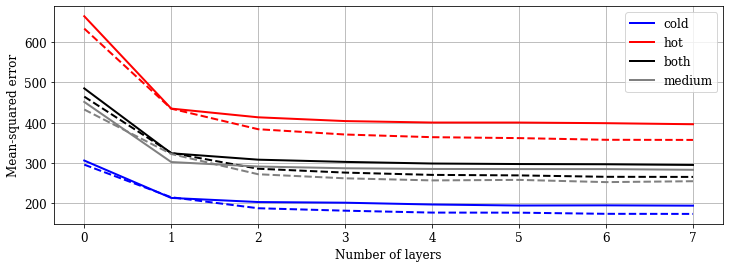

In [126]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    plt.plot(CItest[key]['plot'],label=key,color=color_array[ikey])
    plt.plot(BFtest[key]['plot'],linestyle='--',color=color_array[ikey])
    ikey += 1
    
plt.legend()
plt.grid()
plt.xlabel('Number of layers')
plt.ylabel('Mean-squared error')

# Small data experiments

## Overall parameters

In [29]:
N_batch = 8 # Number of batches for each experiment
Nep = 100
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size_array = 2**np.arange(14,21) # Batch sizes we will consider in these experiments
N_samples = BFgen['cold']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

## Design generators

In [24]:
BFgenSD = {}
CIgenSD = {}

In [25]:
for isize,batch_size in enumerate(batch_size_array):
    BFgenSD[batch_size] = {}
    CIgenSD[batch_size] = {}
    N_batch_max = int(N_samples/batch_size)
    print('batch_size=',batch_size,'& N_batch_max=',N_batch_max)
    
    for iexp in range(N_NN):
        BFgenSD[batch_size][iexp] = {}
        CIgenSD[batch_size][iexp] = {}
        # Randomly select 8 batches
        b_random = np.random.choice(np.linspace(0,N_batch_max-1,N_batch_max),
                                    size=((8,)),
                                    replace=False).astype('int')
        print('Exp#',str(iexp),'b_random=',b_random)
        
        BFgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling=None)
        BFgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling=None)
        
        CIgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling='CI')
        CIgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling='CI')

batch_size= 16384 & N_batch_max= 2879
Exp# 0 b_random= [1004 1594 2203 1458 2262 1577 1916  501]
Exp# 1 b_random= [ 902 2765  360  448 2183 2692 1772 1954]
Exp# 2 b_random= [2192 1290 1719 2693 2067  909 1259  202]
Exp# 3 b_random= [2794 2342 1642 2072  989  345 2664 1291]
Exp# 4 b_random= [2148 1084 2143 1820 2577  524 2526 1779]
Exp# 5 b_random= [ 873 1999  488  283   57  254 1841   17]
Exp# 6 b_random= [ 451 2779 2449   16 2646  954 1263  674]
Exp# 7 b_random= [ 229  740  131 2427  669 2141  755 2300]
Exp# 8 b_random= [1403  323 1832 2428  391 1501 2013 1375]
Exp# 9 b_random= [2579 2821 1091 2269 2701  317 2467 1319]
batch_size= 32768 & N_batch_max= 1439
Exp# 0 b_random= [1415  942  851 1270  940  823   59 1358]
Exp# 1 b_random= [982 735 534 807 878 865 834 431]
Exp# 2 b_random= [ 886  267  141 1140  383  956  260 1260]
Exp# 3 b_random= [ 849  774  991  470  191   43 1347  234]
Exp# 4 b_random= [1328    9 1263  530  248  759 1302 1003]
Exp# 5 b_random= [1276  559 1245  939  794  585

## Train models

In [30]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')

In [31]:
# Inputs
inpBFSD = {}
inpCISD = {}
# Model
NNBFSD = {}
NNCISD = {}
# History
hisBF = {}
hisCI = {}

In [ ]:
for isize,batch_size in enumerate(batch_size_array):
    inpBFSD[batch_size] = {}
    inpCISD[batch_size] = {}
    NNBFSD[batch_size] = {}
    NNCISD[batch_size] = {}
    hisBF[batch_size] = {}
    hisCI[batch_size] = {}
    for iexp in range(N_NN):
        print('batch_size=',batch_size,'& iexp=',iexp)
        # Model definition
        inpBFSD[batch_size][iexp] = Input(shape=(64,))
        inpCISD[batch_size][iexp] = Input(shape=(64,))
        NNBFSD[batch_size][iexp] = NN_model(inpBFSD[batch_size][iexp],N_layer)
        NNCISD[batch_size][iexp] = NN_model(inpCISD[batch_size][iexp],N_layer)
        NNBFSD[batch_size][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        NNCISD[batch_size][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        # Model callbacks
        path_BF = path_data + 'HDF5_DATA/2022_04_29_BF_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
        path_CI = path_data + 'HDF5_DATA/2022_04_29_CI_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
        mcp_BF = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
        mcp_CI = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
        # Model training
        hisBF[batch_size][iexp] = NNBFSD[batch_size][iexp].fit_generator(
            BFgenSD[batch_size][iexp]['train'],epochs=Nep,
            validation_data = BFgenSD[batch_size][iexp]['valid'],
            callbacks=[mcp_BF,earlyStopping])
        hisCI[batch_size][iexp] = NNCISD[batch_size][iexp].fit_generator(
            CIgenSD[batch_size][iexp]['train'],epochs=Nep,
            validation_data = CIgenSD[batch_size][iexp]['valid'],
            callbacks=[mcp_CI,earlyStopping])

batch_size= 16384 & iexp= 0
Epoch 1/100
4/4 [==============================] - 3s 716ms/step - loss: 362.6438 - val_loss: 358.4724
Epoch 2/100
4/4 [==============================] - 1s 161ms/step - loss: 361.6564 - val_loss: 356.4101
Epoch 3/100
4/4 [==============================] - 1s 160ms/step - loss: 358.4153 - val_loss: 351.1514
Epoch 4/100
4/4 [==============================] - 1s 157ms/step - loss: 353.1462 - val_loss: 346.5592
Epoch 5/100
4/4 [==============================] - 1s 177ms/step - loss: 348.9890 - val_loss: 343.2078
Epoch 6/100
4/4 [==============================] - 1s 155ms/step - loss: 345.9872 - val_loss: 340.6371
Epoch 7/100
4/4 [==============================] - 1s 160ms/step - loss: 343.8841 - val_loss: 338.9991
Epoch 8/100
4/4 [==============================] - 1s 153ms/step - loss: 341.7766 - val_loss: 336.3027
Epoch 9/100
4/4 [==============================] - 1s 167ms/step - loss: 338.7049 - val_loss: 332.0883
Epoch 10/100
4/4 [===========================

Epoch 58/100
4/4 [==============================] - 2s 453ms/step - loss: 283.1944 - val_loss: 275.9611
Epoch 59/100
4/4 [==============================] - 2s 430ms/step - loss: 278.5063 - val_loss: 274.8281
Epoch 60/100
4/4 [==============================] - 2s 403ms/step - loss: 276.1135 - val_loss: 271.4488
Epoch 61/100
4/4 [==============================] - 2s 432ms/step - loss: 273.2639 - val_loss: 268.4154
Epoch 62/100
4/4 [==============================] - 1s 365ms/step - loss: 271.8787 - val_loss: 271.6088
Epoch 63/100
4/4 [==============================] - 2s 388ms/step - loss: 273.3712 - val_loss: 271.3732
Epoch 64/100
4/4 [==============================] - 2s 401ms/step - loss: 269.4706 - val_loss: 268.6058
Epoch 65/100
4/4 [==============================] - 2s 421ms/step - loss: 271.1040 - val_loss: 283.7969
Epoch 66/100
4/4 [==============================] - 2s 379ms/step - loss: 295.5650 - val_loss: 327.1783
Epoch 67/100
4/4 [==============================] - 1s 359ms/ste

Epoch 15/100
4/4 [==============================] - 2s 424ms/step - loss: 300.6473 - val_loss: 288.8848
Epoch 16/100
4/4 [==============================] - 2s 414ms/step - loss: 295.5372 - val_loss: 289.5527
Epoch 17/100
4/4 [==============================] - 1s 374ms/step - loss: 293.0748 - val_loss: 282.3261
Epoch 18/100
4/4 [==============================] - 2s 432ms/step - loss: 288.3837 - val_loss: 282.5737
Epoch 19/100
4/4 [==============================] - 2s 452ms/step - loss: 288.6881 - val_loss: 277.7916
Epoch 20/100
4/4 [==============================] - 2s 404ms/step - loss: 283.9965 - val_loss: 283.2063
Epoch 21/100
4/4 [==============================] - 2s 388ms/step - loss: 287.1293 - val_loss: 280.8308
Epoch 22/100
4/4 [==============================] - 2s 380ms/step - loss: 282.9918 - val_loss: 272.4259
Epoch 23/100
4/4 [==============================] - 2s 488ms/step - loss: 278.8948 - val_loss: 269.7221
Epoch 24/100
4/4 [==============================] - 2s 395ms/ste

Epoch 94/100
4/4 [==============================] - 2s 437ms/step - loss: 242.0863 - val_loss: 238.0736
Epoch 95/100
4/4 [==============================] - 2s 474ms/step - loss: 241.9853 - val_loss: 236.2949
Epoch 96/100
4/4 [==============================] - 2s 386ms/step - loss: 238.8671 - val_loss: 238.5822
Epoch 97/100
4/4 [==============================] - 2s 446ms/step - loss: 238.3534 - val_loss: 234.4315
Epoch 98/100
4/4 [==============================] - 2s 402ms/step - loss: 236.7501 - val_loss: 233.7733
Epoch 99/100
4/4 [==============================] - 1s 361ms/step - loss: 236.8052 - val_loss: 234.9178
Epoch 100/100
4/4 [==============================] - 2s 400ms/step - loss: 236.5852 - val_loss: 233.1743
batch_size= 16384 & iexp= 2
Epoch 1/100
4/4 [==============================] - 2s 402ms/step - loss: 364.2462 - val_loss: 367.9775
Epoch 2/100
4/4 [==============================] - 1s 163ms/step - loss: 363.4949 - val_loss: 366.4221
Epoch 3/100
4/4 [====================

Epoch 51/100
4/4 [==============================] - 2s 452ms/step - loss: 244.9205 - val_loss: 251.8821
Epoch 52/100
4/4 [==============================] - 2s 387ms/step - loss: 244.4603 - val_loss: 256.0970
Epoch 53/100
4/4 [==============================] - 2s 451ms/step - loss: 246.9115 - val_loss: 249.8271
Epoch 54/100
4/4 [==============================] - 2s 387ms/step - loss: 243.3677 - val_loss: 258.5799
Epoch 55/100
4/4 [==============================] - 2s 477ms/step - loss: 251.2489 - val_loss: 250.3423
Epoch 56/100
4/4 [==============================] - 2s 429ms/step - loss: 241.5701 - val_loss: 252.6352
Epoch 57/100
4/4 [==============================] - 2s 399ms/step - loss: 247.4502 - val_loss: 251.0829
Epoch 58/100
4/4 [==============================] - 1s 359ms/step - loss: 245.8444 - val_loss: 250.8698
Epoch 59/100
4/4 [==============================] - 1s 366ms/step - loss: 246.7993 - val_loss: 270.3610
Epoch 60/100
4/4 [==============================] - 1s 356ms/ste

Epoch 8/100
4/4 [==============================] - 2s 416ms/step - loss: 307.9380 - val_loss: 303.8217
Epoch 9/100
4/4 [==============================] - 2s 424ms/step - loss: 302.1926 - val_loss: 299.8923
Epoch 10/100
4/4 [==============================] - 2s 405ms/step - loss: 296.4825 - val_loss: 297.5305
Epoch 11/100
4/4 [==============================] - 2s 421ms/step - loss: 293.1939 - val_loss: 291.9522
Epoch 12/100
4/4 [==============================] - 2s 383ms/step - loss: 289.4360 - val_loss: 290.6420
Epoch 13/100
4/4 [==============================] - 2s 467ms/step - loss: 287.1627 - val_loss: 288.1263
Epoch 14/100
4/4 [==============================] - 2s 471ms/step - loss: 286.2662 - val_loss: 284.0720
Epoch 15/100
4/4 [==============================] - 2s 434ms/step - loss: 282.4740 - val_loss: 283.7640
Epoch 16/100
4/4 [==============================] - 2s 404ms/step - loss: 280.6472 - val_loss: 280.4936
Epoch 17/100
4/4 [==============================] - 2s 385ms/step 

Epoch 87/100
4/4 [==============================] - 2s 410ms/step - loss: 254.8466 - val_loss: 254.8653
Epoch 88/100
4/4 [==============================] - 2s 425ms/step - loss: 252.6855 - val_loss: 254.2732
Epoch 89/100
4/4 [==============================] - 2s 408ms/step - loss: 252.1386 - val_loss: 251.1379
Epoch 90/100
4/4 [==============================] - 2s 401ms/step - loss: 250.5221 - val_loss: 254.9347
Epoch 91/100
4/4 [==============================] - 2s 409ms/step - loss: 256.6309 - val_loss: 287.3070
Epoch 92/100
4/4 [==============================] - 1s 350ms/step - loss: 277.9875 - val_loss: 268.6703
Epoch 93/100
4/4 [==============================] - 1s 354ms/step - loss: 264.4243 - val_loss: 266.0401
Epoch 94/100
4/4 [==============================] - 2s 410ms/step - loss: 261.2684 - val_loss: 257.5575
Epoch 95/100
4/4 [==============================] - 2s 390ms/step - loss: 257.5132 - val_loss: 252.5897
Epoch 96/100
4/4 [==============================] - 2s 385ms/ste

Epoch 44/100
4/4 [==============================] - 1s 367ms/step - loss: 259.3005 - val_loss: 280.2446
Epoch 45/100
4/4 [==============================] - 1s 349ms/step - loss: 291.3684 - val_loss: 314.9502
Epoch 46/100
4/4 [==============================] - 1s 357ms/step - loss: 305.4261 - val_loss: 261.3070
Epoch 47/100
4/4 [==============================] - 2s 390ms/step - loss: 271.9665 - val_loss: 273.9383
Epoch 48/100
4/4 [==============================] - 2s 392ms/step - loss: 276.7453 - val_loss: 268.8680
Epoch 49/100
4/4 [==============================] - 1s 370ms/step - loss: 268.8910 - val_loss: 266.3181
Epoch 50/100
4/4 [==============================] - 2s 403ms/step - loss: 265.2656 - val_loss: 258.3559
Epoch 51/100
4/4 [==============================] - 2s 385ms/step - loss: 260.0867 - val_loss: 257.3722
Epoch 52/100
4/4 [==============================] - 2s 414ms/step - loss: 257.8589 - val_loss: 254.4048
Epoch 53/100
4/4 [==============================] - 1s 363ms/ste

Epoch 1/100
4/4 [==============================] - 3s 660ms/step - loss: 376.7981 - val_loss: 354.3624
Epoch 2/100
4/4 [==============================] - 2s 395ms/step - loss: 363.7956 - val_loss: 347.0291
Epoch 3/100
4/4 [==============================] - 2s 445ms/step - loss: 356.5945 - val_loss: 340.0966
Epoch 4/100
4/4 [==============================] - 2s 395ms/step - loss: 349.3286 - val_loss: 333.1544
Epoch 5/100
4/4 [==============================] - 2s 397ms/step - loss: 342.0201 - val_loss: 326.8515
Epoch 6/100
4/4 [==============================] - 2s 416ms/step - loss: 334.0739 - val_loss: 317.7850
Epoch 7/100
4/4 [==============================] - 2s 392ms/step - loss: 325.7508 - val_loss: 309.3712
Epoch 8/100
4/4 [==============================] - 2s 391ms/step - loss: 319.5921 - val_loss: 307.8437
Epoch 9/100
4/4 [==============================] - 2s 402ms/step - loss: 316.2918 - val_loss: 303.0198
Epoch 10/100
4/4 [==============================] - 2s 426ms/step - loss:

Epoch 80/100
4/4 [==============================] - 1s 371ms/step - loss: 302.8280 - val_loss: 286.3953
Epoch 81/100
4/4 [==============================] - 1s 355ms/step - loss: 291.3529 - val_loss: 278.3768
Epoch 82/100
4/4 [==============================] - 2s 399ms/step - loss: 283.5998 - val_loss: 274.6414
Epoch 83/100
4/4 [==============================] - 1s 354ms/step - loss: 277.8514 - val_loss: 269.4123
Epoch 84/100
4/4 [==============================] - 2s 375ms/step - loss: 273.0564 - val_loss: 269.6451
Epoch 85/100
4/4 [==============================] - 2s 452ms/step - loss: 268.2611 - val_loss: 264.6605
Epoch 86/100
4/4 [==============================] - 2s 412ms/step - loss: 267.7080 - val_loss: 256.0609
Epoch 87/100
4/4 [==============================] - 2s 403ms/step - loss: 267.6199 - val_loss: 254.2882
Epoch 88/100
4/4 [==============================] - 2s 452ms/step - loss: 265.2622 - val_loss: 257.6646
Epoch 89/100
4/4 [==============================] - 2s 404ms/ste

Epoch 37/100
4/4 [==============================] - 1s 375ms/step - loss: 261.0556 - val_loss: 269.1317
Epoch 38/100
4/4 [==============================] - 2s 453ms/step - loss: 255.5252 - val_loss: 268.7403
Epoch 39/100
4/4 [==============================] - 2s 422ms/step - loss: 254.5565 - val_loss: 263.7438
Epoch 40/100
4/4 [==============================] - 2s 404ms/step - loss: 251.3941 - val_loss: 265.1319
Epoch 41/100
4/4 [==============================] - 1s 370ms/step - loss: 250.6682 - val_loss: 260.4665
Epoch 42/100
4/4 [==============================] - 2s 402ms/step - loss: 249.8581 - val_loss: 259.1423
Epoch 43/100
4/4 [==============================] - 2s 375ms/step - loss: 248.3334 - val_loss: 258.9602
Epoch 44/100
4/4 [==============================] - 2s 433ms/step - loss: 254.5173 - val_loss: 265.4589
Epoch 45/100
4/4 [==============================] - 1s 357ms/step - loss: 262.9602 - val_loss: 290.1782
Epoch 46/100
4/4 [==============================] - 2s 414ms/ste

Epoch 94/100
4/4 [==============================] - 1s 160ms/step - loss: 231.5619 - val_loss: 238.3370
Epoch 95/100
4/4 [==============================] - 1s 151ms/step - loss: 230.6320 - val_loss: 238.1733
Epoch 96/100
4/4 [==============================] - 1s 138ms/step - loss: 230.3593 - val_loss: 238.8357
Epoch 97/100
4/4 [==============================] - 1s 131ms/step - loss: 230.6082 - val_loss: 239.1045
Epoch 98/100
4/4 [==============================] - 1s 140ms/step - loss: 230.5587 - val_loss: 238.3240
Epoch 99/100
4/4 [==============================] - 1s 133ms/step - loss: 230.1708 - val_loss: 239.3658
Epoch 100/100
4/4 [==============================] - 1s 132ms/step - loss: 230.6881 - val_loss: 238.4734
Epoch 1/100
4/4 [==============================] - 3s 694ms/step - loss: 369.3982 - val_loss: 370.5786
Epoch 2/100
4/4 [==============================] - 2s 449ms/step - loss: 357.2269 - val_loss: 362.7923
Epoch 3/100
4/4 [==============================] - 2s 404ms/step 

Epoch 73/100
4/4 [==============================] - 2s 408ms/step - loss: 243.8046 - val_loss: 274.3637
Epoch 74/100
4/4 [==============================] - 2s 411ms/step - loss: 272.5090 - val_loss: 310.3919
Epoch 75/100
4/4 [==============================] - 2s 426ms/step - loss: 273.9438 - val_loss: 255.1164
Epoch 76/100
4/4 [==============================] - 2s 450ms/step - loss: 252.2301 - val_loss: 265.4854
Epoch 77/100
4/4 [==============================] - 2s 417ms/step - loss: 252.1485 - val_loss: 258.6432
Epoch 78/100
4/4 [==============================] - 2s 410ms/step - loss: 246.6488 - val_loss: 253.7830
Epoch 79/100
4/4 [==============================] - 2s 379ms/step - loss: 243.5499 - val_loss: 250.5194
Epoch 80/100
4/4 [==============================] - 2s 435ms/step - loss: 240.8232 - val_loss: 248.5746
Epoch 81/100
4/4 [==============================] - 2s 378ms/step - loss: 238.5008 - val_loss: 246.8085
Epoch 82/100
4/4 [==============================] - 2s 455ms/ste

Epoch 30/100
4/4 [==============================] - 2s 453ms/step - loss: 276.5760 - val_loss: 279.0267
Epoch 31/100
4/4 [==============================] - 2s 398ms/step - loss: 275.0909 - val_loss: 271.2861
Epoch 32/100
4/4 [==============================] - 2s 388ms/step - loss: 269.3977 - val_loss: 271.8926
Epoch 33/100
4/4 [==============================] - 2s 420ms/step - loss: 270.6698 - val_loss: 271.0884
Epoch 34/100
4/4 [==============================] - 2s 405ms/step - loss: 267.1999 - val_loss: 264.5289
Epoch 35/100
4/4 [==============================] - 2s 380ms/step - loss: 263.6895 - val_loss: 264.2358
Epoch 36/100
4/4 [==============================] - 2s 418ms/step - loss: 263.6717 - val_loss: 263.2600
Epoch 37/100
4/4 [==============================] - 2s 387ms/step - loss: 259.9534 - val_loss: 265.4196
Epoch 38/100
4/4 [==============================] - 2s 452ms/step - loss: 262.2390 - val_loss: 260.0527
Epoch 39/100
4/4 [==============================] - 2s 395ms/ste

Epoch 87/100
4/4 [==============================] - 1s 155ms/step - loss: 229.0784 - val_loss: 231.5398
Epoch 88/100
4/4 [==============================] - 1s 153ms/step - loss: 229.1650 - val_loss: 231.4819
Epoch 89/100
4/4 [==============================] - 1s 137ms/step - loss: 228.4806 - val_loss: 232.6286
Epoch 90/100
4/4 [==============================] - 1s 149ms/step - loss: 228.0597 - val_loss: 231.2558
Epoch 91/100
4/4 [==============================] - 1s 155ms/step - loss: 227.8087 - val_loss: 230.8862
Epoch 92/100
4/4 [==============================] - 1s 150ms/step - loss: 227.7011 - val_loss: 230.5349
Epoch 93/100
4/4 [==============================] - 1s 135ms/step - loss: 227.7665 - val_loss: 230.5758
Epoch 94/100
4/4 [==============================] - 1s 150ms/step - loss: 227.2195 - val_loss: 230.0979
Epoch 95/100
4/4 [==============================] - 1s 142ms/step - loss: 226.7180 - val_loss: 230.3300
Epoch 96/100
4/4 [==============================] - 1s 157ms/ste

Epoch 66/100
4/4 [==============================] - 2s 392ms/step - loss: 266.1937 - val_loss: 260.8538
Epoch 67/100
4/4 [==============================] - 2s 460ms/step - loss: 259.4300 - val_loss: 263.6040
Epoch 68/100
4/4 [==============================] - 2s 453ms/step - loss: 257.9156 - val_loss: 253.1006
Epoch 69/100
4/4 [==============================] - 2s 456ms/step - loss: 250.5800 - val_loss: 251.0281
Epoch 70/100
4/4 [==============================] - 2s 478ms/step - loss: 246.8501 - val_loss: 248.1352
Epoch 71/100
4/4 [==============================] - 1s 360ms/step - loss: 243.8733 - val_loss: 245.3711
Epoch 72/100
4/4 [==============================] - 2s 439ms/step - loss: 241.0802 - val_loss: 242.9305
Epoch 73/100
4/4 [==============================] - 2s 405ms/step - loss: 239.4674 - val_loss: 242.5148
Epoch 74/100
4/4 [==============================] - 1s 373ms/step - loss: 238.3683 - val_loss: 240.4609
Epoch 75/100
4/4 [==============================] - 2s 454ms/ste

4/4 [==============================] - 3s 772ms/step - loss: 271.7511 - val_loss: 276.9838
Epoch 24/100
4/4 [==============================] - 3s 753ms/step - loss: 268.5655 - val_loss: 272.0400
Epoch 25/100
4/4 [==============================] - 3s 692ms/step - loss: 264.9872 - val_loss: 273.7172
Epoch 26/100
4/4 [==============================] - 3s 854ms/step - loss: 274.4273 - val_loss: 284.9852
Epoch 27/100
4/4 [==============================] - 3s 810ms/step - loss: 284.0726 - val_loss: 307.0337
Epoch 28/100
4/4 [==============================] - 3s 830ms/step - loss: 295.8755 - val_loss: 292.7194
Epoch 29/100
4/4 [==============================] - 3s 696ms/step - loss: 287.7925 - val_loss: 283.4146
Epoch 30/100
4/4 [==============================] - 3s 789ms/step - loss: 279.3992 - val_loss: 283.8520
Epoch 31/100
4/4 [==============================] - 3s 793ms/step - loss: 276.2921 - val_loss: 281.4594
Epoch 32/100
4/4 [==============================] - 3s 755ms/step - loss: 271

Epoch 80/100
4/4 [==============================] - 1s 263ms/step - loss: 230.3122 - val_loss: 238.2264
Epoch 81/100
4/4 [==============================] - 1s 253ms/step - loss: 230.1218 - val_loss: 238.0706
Epoch 82/100
4/4 [==============================] - 1s 238ms/step - loss: 230.0113 - val_loss: 237.2395
Epoch 83/100
4/4 [==============================] - 1s 239ms/step - loss: 229.6476 - val_loss: 237.5056
Epoch 84/100
4/4 [==============================] - 1s 268ms/step - loss: 229.6108 - val_loss: 236.2262
Epoch 85/100
4/4 [==============================] - 1s 233ms/step - loss: 228.5977 - val_loss: 236.3644
Epoch 86/100
4/4 [==============================] - 1s 257ms/step - loss: 228.4123 - val_loss: 236.8046
Epoch 87/100
4/4 [==============================] - 1s 262ms/step - loss: 228.2995 - val_loss: 236.4277
Epoch 88/100
4/4 [==============================] - 1s 317ms/step - loss: 228.5392 - val_loss: 235.8423
Epoch 89/100
4/4 [==============================] - 1s 299ms/ste

Epoch 59/100
4/4 [==============================] - 3s 788ms/step - loss: 258.3314 - val_loss: 265.9697
Epoch 60/100
4/4 [==============================] - 3s 803ms/step - loss: 254.4570 - val_loss: 261.8575
Epoch 61/100
4/4 [==============================] - 3s 727ms/step - loss: 251.1682 - val_loss: 259.4634
Epoch 62/100
4/4 [==============================] - 3s 763ms/step - loss: 248.7990 - val_loss: 257.0071
Epoch 63/100
4/4 [==============================] - 3s 766ms/step - loss: 246.7866 - val_loss: 255.3572
Epoch 64/100
4/4 [==============================] - 3s 773ms/step - loss: 245.2415 - val_loss: 256.0436
Epoch 65/100
4/4 [==============================] - 3s 749ms/step - loss: 244.7841 - val_loss: 252.2943
Epoch 66/100
4/4 [==============================] - 3s 724ms/step - loss: 243.6465 - val_loss: 255.9322
Epoch 67/100
4/4 [==============================] - 3s 740ms/step - loss: 242.5748 - val_loss: 249.8742
Epoch 68/100
4/4 [==============================] - 3s 785ms/ste

4/4 [==============================] - 3s 793ms/step - loss: 282.2251 - val_loss: 281.2461
Epoch 17/100
4/4 [==============================] - 3s 799ms/step - loss: 280.0374 - val_loss: 280.5963
Epoch 18/100
4/4 [==============================] - 3s 728ms/step - loss: 278.2025 - val_loss: 281.8263
Epoch 19/100
4/4 [==============================] - 3s 758ms/step - loss: 278.9644 - val_loss: 275.6614
Epoch 20/100
4/4 [==============================] - 3s 769ms/step - loss: 278.7497 - val_loss: 280.8152
Epoch 21/100
4/4 [==============================] - 3s 744ms/step - loss: 276.8043 - val_loss: 277.1401
Epoch 22/100
4/4 [==============================] - 3s 785ms/step - loss: 275.4855 - val_loss: 274.6089
Epoch 23/100
4/4 [==============================] - 3s 871ms/step - loss: 272.1813 - val_loss: 270.6977
Epoch 24/100
4/4 [==============================] - 3s 790ms/step - loss: 268.6545 - val_loss: 268.3741
Epoch 25/100
4/4 [==============================] - 3s 730ms/step - loss: 267

Epoch 95/100
4/4 [==============================] - 3s 786ms/step - loss: 310.8711 - val_loss: 306.9356
Epoch 96/100
4/4 [==============================] - 3s 748ms/step - loss: 303.1880 - val_loss: 301.6295
Epoch 97/100
4/4 [==============================] - 3s 788ms/step - loss: 298.7496 - val_loss: 295.5568
Epoch 98/100
4/4 [==============================] - 3s 738ms/step - loss: 292.0113 - val_loss: 290.9376
Epoch 99/100
4/4 [==============================] - 3s 717ms/step - loss: 287.5295 - val_loss: 291.1364
Epoch 100/100
4/4 [==============================] - 3s 757ms/step - loss: 283.9530 - val_loss: 280.8264
batch_size= 32768 & iexp= 3
Epoch 1/100
4/4 [==============================] - 2s 599ms/step - loss: 368.5774 - val_loss: 358.1430
Epoch 2/100
4/4 [==============================] - 1s 248ms/step - loss: 367.9400 - val_loss: 356.8110
Epoch 3/100
4/4 [==============================] - 1s 277ms/step - loss: 365.8156 - val_loss: 352.9969
Epoch 4/100
4/4 [=====================

4/4 [==============================] - 3s 828ms/step - loss: 253.0271 - val_loss: 246.4442
Epoch 53/100
4/4 [==============================] - 3s 788ms/step - loss: 263.5778 - val_loss: 257.3857
Epoch 54/100
4/4 [==============================] - 3s 737ms/step - loss: 276.9836 - val_loss: 250.1703
Epoch 55/100
4/4 [==============================] - 3s 698ms/step - loss: 281.5325 - val_loss: 277.7965
Epoch 56/100
4/4 [==============================] - 3s 742ms/step - loss: 270.5934 - val_loss: 270.6930
Epoch 57/100
4/4 [==============================] - 3s 788ms/step - loss: 269.4712 - val_loss: 271.8648
Epoch 58/100
4/4 [==============================] - 3s 761ms/step - loss: 264.5912 - val_loss: 262.4958
Epoch 59/100
4/4 [==============================] - 3s 721ms/step - loss: 261.2051 - val_loss: 254.4081
Epoch 60/100
4/4 [==============================] - 3s 786ms/step - loss: 257.4218 - val_loss: 253.3783
Epoch 61/100
4/4 [==============================] - 3s 859ms/step - loss: 253

Epoch 9/100
4/4 [==============================] - 3s 783ms/step - loss: 298.6379 - val_loss: 302.2121
Epoch 10/100
4/4 [==============================] - 3s 714ms/step - loss: 293.8913 - val_loss: 302.3291
Epoch 11/100
4/4 [==============================] - 3s 712ms/step - loss: 292.7568 - val_loss: 306.2479
Epoch 12/100
4/4 [==============================] - 3s 775ms/step - loss: 294.4033 - val_loss: 293.8276
Epoch 13/100
4/4 [==============================] - 3s 799ms/step - loss: 285.8800 - val_loss: 290.5256
Epoch 14/100
4/4 [==============================] - 4s 886ms/step - loss: 283.2234 - val_loss: 289.3181
Epoch 15/100
4/4 [==============================] - 3s 751ms/step - loss: 281.2061 - val_loss: 289.9250
Epoch 16/100
4/4 [==============================] - 3s 764ms/step - loss: 279.6903 - val_loss: 288.7491
Epoch 17/100
4/4 [==============================] - 3s 758ms/step - loss: 277.6682 - val_loss: 283.4995
Epoch 18/100
4/4 [==============================] - 3s 732ms/step

Epoch 88/100
4/4 [==============================] - 3s 766ms/step - loss: 234.9391 - val_loss: 242.2197
Epoch 89/100
4/4 [==============================] - 3s 762ms/step - loss: 235.6971 - val_loss: 240.1248
Epoch 90/100
4/4 [==============================] - 3s 772ms/step - loss: 237.4354 - val_loss: 264.4239
Epoch 91/100
4/4 [==============================] - 3s 735ms/step - loss: 260.9469 - val_loss: 245.4915
Epoch 92/100
4/4 [==============================] - 3s 749ms/step - loss: 243.5314 - val_loss: 249.2352
Epoch 93/100
4/4 [==============================] - 3s 774ms/step - loss: 242.8233 - val_loss: 247.3967
Epoch 94/100
4/4 [==============================] - 3s 690ms/step - loss: 239.1813 - val_loss: 244.7278
Epoch 95/100
4/4 [==============================] - 3s 765ms/step - loss: 236.1299 - val_loss: 243.4643
Epoch 96/100
4/4 [==============================] - 3s 821ms/step - loss: 234.9001 - val_loss: 242.5371
Epoch 97/100
4/4 [==============================] - 3s 796ms/ste

4/4 [==============================] - 3s 792ms/step - loss: 252.7362 - val_loss: 256.8004
Epoch 46/100
4/4 [==============================] - 3s 706ms/step - loss: 250.5842 - val_loss: 256.8718
Epoch 47/100
4/4 [==============================] - 3s 774ms/step - loss: 250.6983 - val_loss: 253.5857
Epoch 48/100
4/4 [==============================] - 3s 789ms/step - loss: 249.6336 - val_loss: 258.7376
Epoch 49/100
4/4 [==============================] - 3s 872ms/step - loss: 248.7568 - val_loss: 253.1077
Epoch 50/100
4/4 [==============================] - 4s 882ms/step - loss: 245.9968 - val_loss: 251.4388
Epoch 51/100
4/4 [==============================] - 3s 777ms/step - loss: 246.5965 - val_loss: 250.7959
Epoch 52/100
4/4 [==============================] - 3s 715ms/step - loss: 253.2339 - val_loss: 252.7685
Epoch 53/100
4/4 [==============================] - 3s 740ms/step - loss: 286.3362 - val_loss: 304.7414
Epoch 54/100
4/4 [==============================] - 3s 762ms/step - loss: 293

Epoch 2/100
4/4 [==============================] - 3s 830ms/step - loss: 356.5201 - val_loss: 347.5242
Epoch 3/100
4/4 [==============================] - 3s 779ms/step - loss: 348.9055 - val_loss: 340.7578
Epoch 4/100
4/4 [==============================] - 3s 807ms/step - loss: 341.4306 - val_loss: 332.8551
Epoch 5/100
4/4 [==============================] - 3s 752ms/step - loss: 333.2925 - val_loss: 324.5860
Epoch 6/100
4/4 [==============================] - 3s 792ms/step - loss: 325.2013 - val_loss: 317.0231
Epoch 7/100
4/4 [==============================] - 3s 740ms/step - loss: 318.2202 - val_loss: 314.1734
Epoch 8/100
4/4 [==============================] - 3s 745ms/step - loss: 311.5957 - val_loss: 305.6039
Epoch 9/100
4/4 [==============================] - 3s 799ms/step - loss: 305.6627 - val_loss: 299.0122
Epoch 10/100
4/4 [==============================] - 3s 820ms/step - loss: 301.2371 - val_loss: 293.1138
Epoch 11/100
4/4 [==============================] - 3s 723ms/step - loss

Epoch 81/100
4/4 [==============================] - 3s 693ms/step - loss: 281.1063 - val_loss: 324.1452
Epoch 82/100
4/4 [==============================] - 3s 756ms/step - loss: 312.2983 - val_loss: 263.2549
Epoch 83/100
4/4 [==============================] - 3s 839ms/step - loss: 280.4492 - val_loss: 286.6869
Epoch 84/100
4/4 [==============================] - 3s 822ms/step - loss: 282.6314 - val_loss: 270.2172
Epoch 85/100
4/4 [==============================] - 3s 740ms/step - loss: 273.5253 - val_loss: 266.5455
Epoch 86/100
4/4 [==============================] - 3s 749ms/step - loss: 269.8585 - val_loss: 263.8053
Epoch 87/100
4/4 [==============================] - 3s 789ms/step - loss: 263.6067 - val_loss: 257.3956
Epoch 88/100
4/4 [==============================] - 3s 770ms/step - loss: 259.9614 - val_loss: 255.4746
Epoch 89/100
4/4 [==============================] - 3s 838ms/step - loss: 257.0998 - val_loss: 252.2608
Epoch 90/100
4/4 [==============================] - 3s 724ms/ste

4/4 [==============================] - 3s 743ms/step - loss: 259.2193 - val_loss: 273.8353
Epoch 39/100
4/4 [==============================] - 3s 766ms/step - loss: 266.3900 - val_loss: 266.8780
Epoch 40/100
4/4 [==============================] - 3s 801ms/step - loss: 259.9278 - val_loss: 258.8487
Epoch 41/100
4/4 [==============================] - 3s 818ms/step - loss: 256.7564 - val_loss: 258.5962
Epoch 42/100
4/4 [==============================] - 3s 816ms/step - loss: 254.2802 - val_loss: 261.1960
Epoch 43/100
4/4 [==============================] - 3s 874ms/step - loss: 254.2121 - val_loss: 255.8219
Epoch 44/100
4/4 [==============================] - 3s 779ms/step - loss: 251.9914 - val_loss: 255.5700
Epoch 45/100
4/4 [==============================] - 3s 744ms/step - loss: 251.7912 - val_loss: 273.7324
Epoch 46/100
4/4 [==============================] - 3s 790ms/step - loss: 262.9730 - val_loss: 254.5993
Epoch 47/100
4/4 [==============================] - 3s 711ms/step - loss: 294

Epoch 95/100
4/4 [==============================] - 1s 276ms/step - loss: 228.4486 - val_loss: 234.0890
Epoch 96/100
4/4 [==============================] - 1s 242ms/step - loss: 227.7667 - val_loss: 233.1853
Epoch 97/100
4/4 [==============================] - 1s 259ms/step - loss: 227.3805 - val_loss: 232.2135
Epoch 98/100
4/4 [==============================] - 1s 270ms/step - loss: 226.7415 - val_loss: 231.8770
Epoch 99/100
4/4 [==============================] - 1s 235ms/step - loss: 226.5106 - val_loss: 231.9319
Epoch 100/100
4/4 [==============================] - 1s 263ms/step - loss: 226.4289 - val_loss: 231.8149
Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 368.7801 - val_loss: 364.0957
Epoch 2/100
4/4 [==============================] - 3s 786ms/step - loss: 352.7462 - val_loss: 356.0405
Epoch 3/100
4/4 [==============================] - 3s 784ms/step - loss: 345.1512 - val_loss: 349.5613
Epoch 4/100
4/4 [==============================] - 3s 729ms/step - lo

Epoch 74/100
4/4 [==============================] - 3s 739ms/step - loss: 333.5645 - val_loss: 337.6130
Epoch 75/100
4/4 [==============================] - 3s 727ms/step - loss: 326.6034 - val_loss: 328.3975
Epoch 76/100
4/4 [==============================] - 3s 731ms/step - loss: 317.7312 - val_loss: 318.8866
Epoch 77/100
4/4 [==============================] - 3s 793ms/step - loss: 308.3590 - val_loss: 309.0350
Epoch 78/100
4/4 [==============================] - 3s 786ms/step - loss: 299.2163 - val_loss: 301.3828
Epoch 79/100
4/4 [==============================] - 3s 838ms/step - loss: 292.2858 - val_loss: 294.4820
Epoch 80/100
4/4 [==============================] - 3s 790ms/step - loss: 285.6346 - val_loss: 288.5711
Epoch 81/100
4/4 [==============================] - 3s 831ms/step - loss: 282.1041 - val_loss: 295.0090
Epoch 82/100
4/4 [==============================] - 3s 874ms/step - loss: 287.8221 - val_loss: 293.7704
Epoch 83/100
4/4 [==============================] - 3s 839ms/ste

4/4 [==============================] - 3s 839ms/step - loss: 297.1129 - val_loss: 308.6728
Epoch 32/100
4/4 [==============================] - 3s 794ms/step - loss: 293.9176 - val_loss: 281.7238
Epoch 33/100
4/4 [==============================] - 3s 766ms/step - loss: 278.6583 - val_loss: 275.0630
Epoch 34/100
4/4 [==============================] - 3s 794ms/step - loss: 272.8421 - val_loss: 276.8581
Epoch 35/100
4/4 [==============================] - 3s 743ms/step - loss: 268.9474 - val_loss: 270.8930
Epoch 36/100
4/4 [==============================] - 3s 779ms/step - loss: 265.3384 - val_loss: 266.8904
Epoch 37/100
4/4 [==============================] - 3s 800ms/step - loss: 261.6245 - val_loss: 265.5329
Epoch 38/100
4/4 [==============================] - 3s 811ms/step - loss: 259.3727 - val_loss: 262.1276
Epoch 39/100
4/4 [==============================] - 3s 777ms/step - loss: 257.1427 - val_loss: 259.6586
Epoch 40/100
4/4 [==============================] - 3s 785ms/step - loss: 255

Epoch 88/100
4/4 [==============================] - 2s 507ms/step - loss: 226.8526 - val_loss: 229.5572
Epoch 89/100
4/4 [==============================] - 2s 516ms/step - loss: 226.6445 - val_loss: 229.3647
Epoch 90/100
4/4 [==============================] - 2s 465ms/step - loss: 226.5281 - val_loss: 229.3146
Epoch 91/100
4/4 [==============================] - 2s 472ms/step - loss: 226.3729 - val_loss: 229.6576
Epoch 92/100
4/4 [==============================] - 2s 467ms/step - loss: 227.4947 - val_loss: 230.4987
Epoch 93/100
4/4 [==============================] - 2s 474ms/step - loss: 227.1791 - val_loss: 228.8308
Epoch 94/100
4/4 [==============================] - 2s 497ms/step - loss: 226.1343 - val_loss: 228.6330
Epoch 95/100
4/4 [==============================] - 2s 473ms/step - loss: 225.8234 - val_loss: 228.7343
Epoch 96/100
4/4 [==============================] - 2s 477ms/step - loss: 226.4193 - val_loss: 228.5082
Epoch 97/100
4/4 [==============================] - 2s 477ms/ste

Epoch 69/100
4/4 [==============================] - 7s 2s/step - loss: 267.1585 - val_loss: 270.2854
Epoch 70/100
4/4 [==============================] - 7s 2s/step - loss: 262.4945 - val_loss: 264.9363
Epoch 71/100
4/4 [==============================] - 7s 2s/step - loss: 259.1036 - val_loss: 262.5075
Epoch 72/100
4/4 [==============================] - 7s 2s/step - loss: 257.6724 - val_loss: 261.0143
Epoch 73/100
4/4 [==============================] - 7s 2s/step - loss: 255.3099 - val_loss: 256.8588
Epoch 74/100
4/4 [==============================] - 7s 2s/step - loss: 253.7213 - val_loss: 255.6049
Epoch 75/100
4/4 [==============================] - 7s 2s/step - loss: 251.9585 - val_loss: 254.3470
Epoch 76/100
4/4 [==============================] - 7s 2s/step - loss: 250.6377 - val_loss: 252.3892
Epoch 77/100
4/4 [==============================] - 7s 2s/step - loss: 250.0155 - val_loss: 251.1051
Epoch 78/100
4/4 [==============================] - 7s 2s/step - loss: 252.8318 - val_loss:

4/4 [==============================] - 7s 2s/step - loss: 268.4960 - val_loss: 270.3738
Epoch 28/100
4/4 [==============================] - 7s 2s/step - loss: 266.2273 - val_loss: 267.8616
Epoch 29/100
4/4 [==============================] - 7s 2s/step - loss: 264.2634 - val_loss: 268.5172
Epoch 30/100
4/4 [==============================] - 7s 2s/step - loss: 263.5065 - val_loss: 264.6389
Epoch 31/100
4/4 [==============================] - 7s 2s/step - loss: 263.4651 - val_loss: 267.6656
Epoch 32/100
4/4 [==============================] - 6s 2s/step - loss: 268.6677 - val_loss: 296.4599
Epoch 33/100
4/4 [==============================] - 7s 2s/step - loss: 291.7787 - val_loss: 303.4244
Epoch 34/100
4/4 [==============================] - 7s 2s/step - loss: 285.7253 - val_loss: 268.2401
Epoch 35/100
4/4 [==============================] - 7s 2s/step - loss: 273.5872 - val_loss: 284.8191
Epoch 36/100
4/4 [==============================] - 7s 2s/step - loss: 273.0178 - val_loss: 272.0748
Epo

Epoch 8/100
4/4 [==============================] - 2s 499ms/step - loss: 347.6322 - val_loss: 345.9870
Epoch 9/100
4/4 [==============================] - 2s 459ms/step - loss: 345.7783 - val_loss: 343.7050
Epoch 10/100
4/4 [==============================] - 2s 473ms/step - loss: 342.9879 - val_loss: 339.3022
Epoch 11/100
4/4 [==============================] - 2s 500ms/step - loss: 337.5932 - val_loss: 330.9149
Epoch 12/100
4/4 [==============================] - 2s 489ms/step - loss: 326.9865 - val_loss: 314.9913
Epoch 13/100
4/4 [==============================] - 2s 530ms/step - loss: 311.5693 - val_loss: 299.5125
Epoch 14/100
4/4 [==============================] - 2s 475ms/step - loss: 297.3320 - val_loss: 286.6481
Epoch 15/100
4/4 [==============================] - 2s 480ms/step - loss: 286.1962 - val_loss: 279.2404
Epoch 16/100
4/4 [==============================] - 2s 496ms/step - loss: 279.3631 - val_loss: 275.3523
Epoch 17/100
4/4 [==============================] - 2s 488ms/step 

Epoch 87/100
4/4 [==============================] - 2s 503ms/step - loss: 232.6975 - val_loss: 231.6543
Epoch 88/100
4/4 [==============================] - 2s 435ms/step - loss: 232.6477 - val_loss: 232.0350
Epoch 89/100
4/4 [==============================] - 2s 489ms/step - loss: 232.5320 - val_loss: 231.4805
Epoch 90/100
4/4 [==============================] - 2s 510ms/step - loss: 232.2186 - val_loss: 231.2811
Epoch 91/100
4/4 [==============================] - 2s 464ms/step - loss: 232.3320 - val_loss: 231.6453
Epoch 92/100
4/4 [==============================] - 2s 497ms/step - loss: 232.0655 - val_loss: 232.8478
Epoch 93/100
4/4 [==============================] - 2s 458ms/step - loss: 231.9966 - val_loss: 230.8931
Epoch 94/100
4/4 [==============================] - 2s 499ms/step - loss: 231.6192 - val_loss: 230.5624
Epoch 95/100
4/4 [==============================] - 2s 477ms/step - loss: 231.6785 - val_loss: 231.0366
Epoch 96/100
4/4 [==============================] - 2s 510ms/ste

Epoch 68/100
4/4 [==============================] - 7s 2s/step - loss: 277.7071 - val_loss: 309.4747
Epoch 69/100
4/4 [==============================] - 7s 2s/step - loss: 273.3363 - val_loss: 249.6983
Epoch 70/100
4/4 [==============================] - 7s 2s/step - loss: 257.5848 - val_loss: 257.3885
Epoch 71/100
4/4 [==============================] - 7s 2s/step - loss: 256.6129 - val_loss: 248.9341
Epoch 72/100
4/4 [==============================] - 6s 2s/step - loss: 251.8295 - val_loss: 250.5104
Epoch 73/100
4/4 [==============================] - 7s 2s/step - loss: 250.2087 - val_loss: 249.3395
Epoch 74/100
4/4 [==============================] - 7s 2s/step - loss: 247.9566 - val_loss: 244.7710
Epoch 75/100
4/4 [==============================] - 7s 2s/step - loss: 245.8581 - val_loss: 244.1147
Epoch 76/100
4/4 [==============================] - 7s 2s/step - loss: 244.8550 - val_loss: 242.5362
Epoch 77/100
4/4 [==============================] - 7s 2s/step - loss: 243.6717 - val_loss:

4/4 [==============================] - 7s 2s/step - loss: 278.9440 - val_loss: 313.5793
Epoch 27/100
4/4 [==============================] - 7s 2s/step - loss: 294.6195 - val_loss: 288.0559
Epoch 28/100
4/4 [==============================] - 6s 2s/step - loss: 287.0372 - val_loss: 272.9770
Epoch 29/100
4/4 [==============================] - 7s 2s/step - loss: 276.6471 - val_loss: 288.9503
Epoch 30/100
4/4 [==============================] - 7s 2s/step - loss: 277.0953 - val_loss: 275.0561
Epoch 31/100
4/4 [==============================] - 7s 2s/step - loss: 271.4883 - val_loss: 275.7560
Epoch 32/100
4/4 [==============================] - 7s 2s/step - loss: 270.2556 - val_loss: 269.8081
Epoch 33/100
4/4 [==============================] - 7s 2s/step - loss: 266.8068 - val_loss: 270.9881
Epoch 34/100
4/4 [==============================] - 7s 2s/step - loss: 264.7200 - val_loss: 268.8957
Epoch 35/100
4/4 [==============================] - 7s 2s/step - loss: 262.8740 - val_loss: 266.9003
Epo

Epoch 7/100
4/4 [==============================] - 2s 509ms/step - loss: 346.7970 - val_loss: 343.5084
Epoch 8/100
4/4 [==============================] - 2s 543ms/step - loss: 343.2047 - val_loss: 338.6862
Epoch 9/100
4/4 [==============================] - 2s 497ms/step - loss: 337.4567 - val_loss: 331.3260
Epoch 10/100
4/4 [==============================] - 2s 491ms/step - loss: 328.2652 - val_loss: 319.5196
Epoch 11/100
4/4 [==============================] - 2s 499ms/step - loss: 314.6672 - val_loss: 303.6452
Epoch 12/100
4/4 [==============================] - 2s 525ms/step - loss: 299.8589 - val_loss: 290.8748
Epoch 13/100
4/4 [==============================] - 2s 555ms/step - loss: 288.6493 - val_loss: 281.4839
Epoch 14/100
4/4 [==============================] - 2s 520ms/step - loss: 280.7740 - val_loss: 275.6619
Epoch 15/100
4/4 [==============================] - 2s 508ms/step - loss: 276.2083 - val_loss: 273.1632
Epoch 16/100
4/4 [==============================] - 2s 523ms/step -

Epoch 86/100
4/4 [==============================] - 2s 534ms/step - loss: 232.5006 - val_loss: 231.9885
Epoch 87/100
4/4 [==============================] - 2s 530ms/step - loss: 232.5892 - val_loss: 231.6293
Epoch 88/100
4/4 [==============================] - 2s 524ms/step - loss: 232.4281 - val_loss: 231.2222
Epoch 89/100
4/4 [==============================] - 2s 548ms/step - loss: 231.9086 - val_loss: 231.1000
Epoch 90/100
4/4 [==============================] - 2s 460ms/step - loss: 231.4322 - val_loss: 231.2876
Epoch 91/100
4/4 [==============================] - 2s 509ms/step - loss: 231.6993 - val_loss: 230.4470
Epoch 92/100
4/4 [==============================] - 2s 502ms/step - loss: 231.4775 - val_loss: 231.0854
Epoch 93/100
4/4 [==============================] - 2s 501ms/step - loss: 231.3500 - val_loss: 230.2336
Epoch 94/100
4/4 [==============================] - 2s 492ms/step - loss: 230.7966 - val_loss: 230.3677
Epoch 95/100
4/4 [==============================] - 2s 510ms/ste

4/4 [==============================] - 2s 488ms/step - loss: 259.3124 - val_loss: 257.0636
Epoch 46/100
4/4 [==============================] - 2s 522ms/step - loss: 258.6273 - val_loss: 256.8025
Epoch 47/100
4/4 [==============================] - 2s 492ms/step - loss: 258.4620 - val_loss: 256.5383
Epoch 48/100
4/4 [==============================] - 2s 497ms/step - loss: 258.4428 - val_loss: 256.2785
Epoch 49/100
4/4 [==============================] - 2s 522ms/step - loss: 257.6312 - val_loss: 255.3109
Epoch 50/100
4/4 [==============================] - 2s 519ms/step - loss: 257.0871 - val_loss: 255.2879
Epoch 51/100
4/4 [==============================] - 2s 539ms/step - loss: 256.9831 - val_loss: 254.6827
Epoch 52/100
4/4 [==============================] - 2s 559ms/step - loss: 255.9194 - val_loss: 254.4000
Epoch 53/100
4/4 [==============================] - 2s 504ms/step - loss: 256.0275 - val_loss: 253.7396
Epoch 54/100
4/4 [==============================] - 2s 513ms/step - loss: 255

Epoch 5/100
4/4 [==============================] - 2s 491ms/step - loss: 352.7680 - val_loss: 350.5246
Epoch 6/100
4/4 [==============================] - 2s 520ms/step - loss: 350.3570 - val_loss: 347.8124
Epoch 7/100
4/4 [==============================] - 2s 543ms/step - loss: 347.9872 - val_loss: 345.4957
Epoch 8/100
4/4 [==============================] - 2s 501ms/step - loss: 344.7218 - val_loss: 340.2060
Epoch 9/100
4/4 [==============================] - 2s 527ms/step - loss: 338.3281 - val_loss: 332.0957
Epoch 10/100
4/4 [==============================] - 2s 522ms/step - loss: 328.7385 - val_loss: 320.9830
Epoch 11/100
4/4 [==============================] - 2s 533ms/step - loss: 316.9963 - val_loss: 308.3176
Epoch 12/100
4/4 [==============================] - 2s 538ms/step - loss: 303.6172 - val_loss: 295.4938
Epoch 13/100
4/4 [==============================] - 2s 479ms/step - loss: 292.0352 - val_loss: 286.2606
Epoch 14/100
4/4 [==============================] - 2s 533ms/step - l

Epoch 84/100
4/4 [==============================] - 2s 492ms/step - loss: 236.8768 - val_loss: 237.5197
Epoch 85/100
4/4 [==============================] - 2s 542ms/step - loss: 235.7650 - val_loss: 236.6366
Epoch 86/100
4/4 [==============================] - 2s 479ms/step - loss: 235.3515 - val_loss: 236.8872
Epoch 87/100
4/4 [==============================] - 2s 521ms/step - loss: 236.0065 - val_loss: 236.7128
Epoch 88/100
4/4 [==============================] - 2s 532ms/step - loss: 235.3256 - val_loss: 236.3526
Epoch 89/100
4/4 [==============================] - 2s 497ms/step - loss: 235.1714 - val_loss: 236.3419
Epoch 90/100
4/4 [==============================] - 2s 495ms/step - loss: 234.9282 - val_loss: 236.2445
Epoch 91/100
4/4 [==============================] - 2s 520ms/step - loss: 234.9302 - val_loss: 236.8708
Epoch 92/100
4/4 [==============================] - 2s 496ms/step - loss: 234.9649 - val_loss: 237.0592
Epoch 93/100
4/4 [==============================] - 2s 504ms/ste

Epoch 44/100
4/4 [==============================] - 2s 500ms/step - loss: 254.7019 - val_loss: 252.4670
Epoch 45/100
4/4 [==============================] - 2s 515ms/step - loss: 254.1411 - val_loss: 252.0538
Epoch 46/100
4/4 [==============================] - 2s 485ms/step - loss: 253.6904 - val_loss: 251.7111
Epoch 47/100
4/4 [==============================] - 2s 488ms/step - loss: 253.3616 - val_loss: 251.8113
Epoch 48/100
4/4 [==============================] - 2s 516ms/step - loss: 252.9925 - val_loss: 250.7559
Epoch 49/100
4/4 [==============================] - 2s 503ms/step - loss: 252.4089 - val_loss: 250.3984
Epoch 50/100
4/4 [==============================] - 2s 485ms/step - loss: 252.0442 - val_loss: 249.8420
Epoch 51/100
4/4 [==============================] - 2s 519ms/step - loss: 251.3608 - val_loss: 249.7244
Epoch 52/100
4/4 [==============================] - 2s 498ms/step - loss: 251.0791 - val_loss: 250.2627
Epoch 53/100
4/4 [==============================] - 2s 518ms/ste

Epoch 4/100
4/4 [==============================] - 2s 528ms/step - loss: 358.4811 - val_loss: 350.9556
Epoch 5/100
4/4 [==============================] - 2s 492ms/step - loss: 353.1978 - val_loss: 346.6065
Epoch 6/100
4/4 [==============================] - 2s 513ms/step - loss: 348.2385 - val_loss: 341.5343
Epoch 7/100
4/4 [==============================] - 2s 516ms/step - loss: 343.1818 - val_loss: 335.6459
Epoch 8/100
4/4 [==============================] - 2s 532ms/step - loss: 336.1219 - val_loss: 326.4222
Epoch 9/100
4/4 [==============================] - 2s 493ms/step - loss: 325.4440 - val_loss: 314.8981
Epoch 10/100
4/4 [==============================] - 2s 501ms/step - loss: 313.2037 - val_loss: 303.0539
Epoch 11/100
4/4 [==============================] - 2s 495ms/step - loss: 300.9490 - val_loss: 292.0482
Epoch 12/100
4/4 [==============================] - 2s 554ms/step - loss: 290.3551 - val_loss: 283.3717
Epoch 13/100
4/4 [==============================] - 2s 484ms/step - lo

Epoch 83/100
4/4 [==============================] - 2s 438ms/step - loss: 233.4992 - val_loss: 233.5482
Epoch 84/100
4/4 [==============================] - 2s 532ms/step - loss: 233.3555 - val_loss: 232.3345
Epoch 85/100
4/4 [==============================] - 2s 498ms/step - loss: 232.9635 - val_loss: 231.5645
Epoch 86/100
4/4 [==============================] - 2s 486ms/step - loss: 232.4449 - val_loss: 231.8468
Epoch 87/100
4/4 [==============================] - 2s 494ms/step - loss: 232.8666 - val_loss: 231.4944
Epoch 88/100
4/4 [==============================] - 2s 473ms/step - loss: 232.5283 - val_loss: 233.1508
Epoch 89/100
4/4 [==============================] - 2s 505ms/step - loss: 234.0083 - val_loss: 232.3808
Epoch 90/100
4/4 [==============================] - 2s 494ms/step - loss: 234.4030 - val_loss: 232.7658
Epoch 91/100
4/4 [==============================] - 2s 481ms/step - loss: 233.4307 - val_loss: 233.2372
Epoch 92/100
4/4 [==============================] - 2s 486ms/ste

Epoch 43/100
4/4 [==============================] - 2s 531ms/step - loss: 253.2660 - val_loss: 257.3288
Epoch 44/100
4/4 [==============================] - 2s 495ms/step - loss: 252.4817 - val_loss: 256.3319
Epoch 45/100
4/4 [==============================] - 2s 461ms/step - loss: 252.5786 - val_loss: 258.6801
Epoch 46/100
4/4 [==============================] - 2s 486ms/step - loss: 251.8687 - val_loss: 255.2830
Epoch 47/100
4/4 [==============================] - 2s 468ms/step - loss: 250.8896 - val_loss: 254.6813
Epoch 48/100
4/4 [==============================] - 2s 472ms/step - loss: 250.0220 - val_loss: 255.0596
Epoch 49/100
4/4 [==============================] - 2s 498ms/step - loss: 249.5975 - val_loss: 254.2270
Epoch 50/100
4/4 [==============================] - 2s 495ms/step - loss: 249.0298 - val_loss: 252.9455
Epoch 51/100
4/4 [==============================] - 2s 485ms/step - loss: 248.1432 - val_loss: 253.7329
Epoch 52/100
4/4 [==============================] - 2s 538ms/ste

Epoch 3/100
4/4 [==============================] - 4s 993ms/step - loss: 364.0714 - val_loss: 365.3444
Epoch 4/100
4/4 [==============================] - 4s 907ms/step - loss: 359.2412 - val_loss: 360.7125
Epoch 5/100
4/4 [==============================] - 4s 939ms/step - loss: 355.3259 - val_loss: 356.9775
Epoch 6/100
4/4 [==============================] - 4s 982ms/step - loss: 351.7018 - val_loss: 353.7952
Epoch 7/100
4/4 [==============================] - 4s 946ms/step - loss: 348.7866 - val_loss: 351.2448
Epoch 8/100
4/4 [==============================] - 4s 960ms/step - loss: 345.9721 - val_loss: 347.3884
Epoch 9/100
4/4 [==============================] - 4s 974ms/step - loss: 341.3458 - val_loss: 340.9948
Epoch 10/100
4/4 [==============================] - 4s 900ms/step - loss: 333.7438 - val_loss: 331.8049
Epoch 11/100
4/4 [==============================] - 4s 959ms/step - loss: 323.9964 - val_loss: 320.2846
Epoch 12/100
4/4 [==============================] - 4s 921ms/step - los

4/4 [==============================] - 14s 4s/step - loss: 254.4830 - val_loss: 253.0953
Epoch 63/100
4/4 [==============================] - 14s 4s/step - loss: 251.2858 - val_loss: 250.8055
Epoch 64/100
4/4 [==============================] - 14s 4s/step - loss: 248.4370 - val_loss: 251.0363
Epoch 65/100
4/4 [==============================] - 15s 4s/step - loss: 247.2353 - val_loss: 249.5645
Epoch 66/100
4/4 [==============================] - 15s 4s/step - loss: 246.2483 - val_loss: 248.1443
Epoch 67/100
4/4 [==============================] - 14s 4s/step - loss: 244.6525 - val_loss: 246.3438
Epoch 68/100
4/4 [==============================] - 14s 4s/step - loss: 244.8170 - val_loss: 248.1128
Epoch 69/100
4/4 [==============================] - 15s 4s/step - loss: 246.9605 - val_loss: 250.5477
Epoch 70/100
4/4 [==============================] - 15s 4s/step - loss: 243.6354 - val_loss: 245.7794
Epoch 71/100
4/4 [==============================] - 14s 4s/step - loss: 242.2083 - val_loss: 24

Epoch 22/100
4/4 [==============================] - 15s 4s/step - loss: 286.2014 - val_loss: 285.7870
Epoch 23/100
4/4 [==============================] - 14s 4s/step - loss: 282.4472 - val_loss: 282.3517
Epoch 24/100
4/4 [==============================] - 14s 4s/step - loss: 280.5484 - val_loss: 284.0883
Epoch 25/100
4/4 [==============================] - 14s 4s/step - loss: 277.5377 - val_loss: 279.3836
Epoch 26/100
4/4 [==============================] - 15s 4s/step - loss: 274.4205 - val_loss: 274.1036
Epoch 27/100
4/4 [==============================] - 14s 4s/step - loss: 272.1781 - val_loss: 273.8524
Epoch 28/100
4/4 [==============================] - 15s 4s/step - loss: 270.2363 - val_loss: 270.4892
Epoch 29/100
4/4 [==============================] - 14s 4s/step - loss: 267.7788 - val_loss: 268.6451
Epoch 30/100
4/4 [==============================] - 15s 4s/step - loss: 266.0738 - val_loss: 267.4990
Epoch 31/100
4/4 [==============================] - 15s 4s/step - loss: 264.0992 -

4/4 [==============================] - 4s 1s/step - loss: 365.3741 - val_loss: 363.1104
Epoch 3/100
4/4 [==============================] - 4s 901ms/step - loss: 362.8059 - val_loss: 359.1531
Epoch 4/100
4/4 [==============================] - 4s 980ms/step - loss: 358.5812 - val_loss: 354.3225
Epoch 5/100
4/4 [==============================] - 4s 892ms/step - loss: 353.4973 - val_loss: 350.8998
Epoch 6/100
4/4 [==============================] - 4s 997ms/step - loss: 350.6461 - val_loss: 347.9369
Epoch 7/100
4/4 [==============================] - 4s 955ms/step - loss: 348.3054 - val_loss: 346.7580
Epoch 8/100
4/4 [==============================] - 4s 927ms/step - loss: 346.6886 - val_loss: 344.3882
Epoch 9/100
4/4 [==============================] - 4s 971ms/step - loss: 343.9115 - val_loss: 340.5952
Epoch 10/100
4/4 [==============================] - 4s 1s/step - loss: 338.6792 - val_loss: 333.2270
Epoch 11/100
4/4 [==============================] - 4s 960ms/step - loss: 328.7662 - val_l

4/4 [==============================] - 15s 4s/step - loss: 247.8630 - val_loss: 248.6640
Epoch 62/100
4/4 [==============================] - 15s 4s/step - loss: 245.9705 - val_loss: 248.2194
Epoch 63/100
4/4 [==============================] - 14s 4s/step - loss: 245.3379 - val_loss: 249.4075
Epoch 64/100
4/4 [==============================] - 15s 4s/step - loss: 244.5288 - val_loss: 245.1518
Epoch 65/100
4/4 [==============================] - 14s 4s/step - loss: 244.4677 - val_loss: 249.8048
Epoch 66/100
4/4 [==============================] - 15s 4s/step - loss: 246.3620 - val_loss: 252.7843
Epoch 67/100
4/4 [==============================] - 14s 4s/step - loss: 248.4526 - val_loss: 261.5490
Epoch 68/100
4/4 [==============================] - 14s 4s/step - loss: 261.6448 - val_loss: 285.3989
Epoch 69/100
4/4 [==============================] - 14s 4s/step - loss: 276.5752 - val_loss: 302.1864
Epoch 70/100
4/4 [==============================] - 14s 3s/step - loss: 283.2866 - val_loss: 25

4/4 [==============================] - 14s 4s/step - loss: 283.0072 - val_loss: 281.8156
Epoch 20/100
4/4 [==============================] - 14s 4s/step - loss: 279.3006 - val_loss: 279.7463
Epoch 21/100
4/4 [==============================] - 15s 4s/step - loss: 277.7993 - val_loss: 277.6906
Epoch 22/100
4/4 [==============================] - 14s 4s/step - loss: 275.7699 - val_loss: 278.2146
Epoch 23/100
4/4 [==============================] - 14s 4s/step - loss: 278.8994 - val_loss: 277.9088
Epoch 24/100
4/4 [==============================] - 14s 4s/step - loss: 277.7869 - val_loss: 277.4891
Epoch 25/100
4/4 [==============================] - 15s 4s/step - loss: 275.2669 - val_loss: 271.2947
Epoch 26/100
4/4 [==============================] - 14s 4s/step - loss: 271.9780 - val_loss: 270.7924
Epoch 27/100
4/4 [==============================] - 14s 4s/step - loss: 272.4010 - val_loss: 270.1064
Epoch 28/100
4/4 [==============================] - 14s 3s/step - loss: 270.1668 - val_loss: 27

4/4 [==============================] - 4s 1s/step - loss: 233.6863 - val_loss: 231.4718
Epoch 79/100
4/4 [==============================] - 4s 930ms/step - loss: 233.2409 - val_loss: 232.1647
Epoch 80/100
4/4 [==============================] - 4s 988ms/step - loss: 233.2667 - val_loss: 231.2604
Epoch 81/100
4/4 [==============================] - 4s 990ms/step - loss: 232.8035 - val_loss: 231.0585
Epoch 82/100
4/4 [==============================] - 4s 1s/step - loss: 232.8719 - val_loss: 230.4336
Epoch 83/100
4/4 [==============================] - 4s 1s/step - loss: 232.2181 - val_loss: 230.2301
Epoch 84/100
4/4 [==============================] - 4s 938ms/step - loss: 232.1445 - val_loss: 230.6044
Epoch 85/100
4/4 [==============================] - 4s 1s/step - loss: 232.3854 - val_loss: 229.9315
Epoch 86/100
4/4 [==============================] - 4s 1s/step - loss: 232.0397 - val_loss: 231.2584
Epoch 87/100
4/4 [==============================] - 4s 1s/step - loss: 232.0350 - val_loss: 

Epoch 38/100
4/4 [==============================] - 4s 981ms/step - loss: 254.9948 - val_loss: 254.3183
Epoch 39/100
4/4 [==============================] - 4s 923ms/step - loss: 254.4439 - val_loss: 253.2310
Epoch 40/100
4/4 [==============================] - 4s 958ms/step - loss: 253.8672 - val_loss: 252.8794
Epoch 41/100
4/4 [==============================] - 4s 1s/step - loss: 253.4516 - val_loss: 252.4545
Epoch 42/100
4/4 [==============================] - 4s 919ms/step - loss: 252.8509 - val_loss: 252.1701
Epoch 43/100
4/4 [==============================] - 4s 991ms/step - loss: 252.5965 - val_loss: 251.7249
Epoch 44/100
4/4 [==============================] - 4s 1s/step - loss: 252.2431 - val_loss: 251.9630
Epoch 45/100
4/4 [==============================] - 4s 1s/step - loss: 251.8025 - val_loss: 251.1194
Epoch 46/100
4/4 [==============================] - 4s 980ms/step - loss: 251.4021 - val_loss: 250.8614
Epoch 47/100
4/4 [==============================] - 4s 900ms/step - loss:

Epoch 18/100
4/4 [==============================] - 15s 4s/step - loss: 288.9513 - val_loss: 293.0264
Epoch 19/100
4/4 [==============================] - 15s 4s/step - loss: 285.5902 - val_loss: 285.8225
Epoch 20/100
4/4 [==============================] - 15s 4s/step - loss: 281.3414 - val_loss: 276.8038
Epoch 21/100
4/4 [==============================] - 14s 4s/step - loss: 277.6367 - val_loss: 275.5149
Epoch 22/100
4/4 [==============================] - 15s 4s/step - loss: 275.7449 - val_loss: 273.9500
Epoch 23/100
4/4 [==============================] - 15s 4s/step - loss: 273.4163 - val_loss: 271.4780
Epoch 24/100
4/4 [==============================] - 15s 4s/step - loss: 271.5927 - val_loss: 269.1123
Epoch 25/100
4/4 [==============================] - 14s 4s/step - loss: 269.6258 - val_loss: 270.5689
Epoch 26/100
4/4 [==============================] - 14s 4s/step - loss: 274.1844 - val_loss: 271.0921
Epoch 27/100
4/4 [==============================] - 15s 4s/step - loss: 270.9730 -

4/4 [==============================] - 4s 994ms/step - loss: 234.2806 - val_loss: 234.4246
Epoch 78/100
4/4 [==============================] - 4s 920ms/step - loss: 234.6268 - val_loss: 234.5951
Epoch 79/100
4/4 [==============================] - 4s 980ms/step - loss: 234.3119 - val_loss: 233.9861
Epoch 80/100
4/4 [==============================] - 4s 938ms/step - loss: 234.0658 - val_loss: 234.0863
Epoch 81/100
4/4 [==============================] - 4s 1s/step - loss: 234.1126 - val_loss: 233.9182
Epoch 82/100
4/4 [==============================] - 4s 1s/step - loss: 233.1816 - val_loss: 233.3944
Epoch 83/100
4/4 [==============================] - 4s 985ms/step - loss: 232.9175 - val_loss: 233.0422
Epoch 84/100
4/4 [==============================] - 4s 880ms/step - loss: 233.2078 - val_loss: 233.3624
Epoch 85/100
4/4 [==============================] - 4s 971ms/step - loss: 232.7870 - val_loss: 232.4321
Epoch 86/100
4/4 [==============================] - 4s 911ms/step - loss: 233.2424 

Epoch 37/100
4/4 [==============================] - 4s 928ms/step - loss: 257.2988 - val_loss: 254.2052
Epoch 38/100
4/4 [==============================] - 4s 902ms/step - loss: 256.8464 - val_loss: 254.3037
Epoch 39/100
4/4 [==============================] - 4s 1s/step - loss: 256.5774 - val_loss: 253.0771
Epoch 40/100
4/4 [==============================] - 4s 929ms/step - loss: 255.7852 - val_loss: 252.8890
Epoch 41/100
4/4 [==============================] - 3s 872ms/step - loss: 255.2284 - val_loss: 252.4942
Epoch 42/100
4/4 [==============================] - 4s 1s/step - loss: 254.6808 - val_loss: 251.2209
Epoch 43/100
4/4 [==============================] - 4s 967ms/step - loss: 254.0094 - val_loss: 251.1428
Epoch 44/100
4/4 [==============================] - 4s 969ms/step - loss: 253.5224 - val_loss: 249.7871
Epoch 45/100
4/4 [==============================] - 4s 946ms/step - loss: 253.2100 - val_loss: 249.4719
Epoch 46/100
4/4 [==============================] - 3s 861ms/step - lo

4/4 [==============================] - 15s 4s/step - loss: 274.9335 - val_loss: 273.9260
Epoch 97/100
4/4 [==============================] - 14s 4s/step - loss: 273.5512 - val_loss: 264.0201
Epoch 98/100
4/4 [==============================] - 14s 4s/step - loss: 264.6578 - val_loss: 259.7760
Epoch 99/100
4/4 [==============================] - 14s 4s/step - loss: 260.8770 - val_loss: 253.5987
Epoch 100/100
4/4 [==============================] - 15s 4s/step - loss: 258.3111 - val_loss: 258.8997
batch_size= 131072 & iexp= 8
Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 370.9209 - val_loss: 361.9682
Epoch 2/100
4/4 [==============================] - 4s 969ms/step - loss: 370.0074 - val_loss: 360.1113
Epoch 3/100
4/4 [==============================] - 4s 888ms/step - loss: 367.2258 - val_loss: 355.9621
Epoch 4/100
4/4 [==============================] - 4s 945ms/step - loss: 362.9550 - val_loss: 351.2055
Epoch 5/100
4/4 [==============================] - 4s 1s/step - 

4/4 [==============================] - 15s 4s/step - loss: 249.4493 - val_loss: 246.7162
Epoch 56/100
4/4 [==============================] - 15s 4s/step - loss: 248.9779 - val_loss: 254.4641
Epoch 57/100
4/4 [==============================] - 14s 4s/step - loss: 264.2826 - val_loss: 316.2590
Epoch 58/100
4/4 [==============================] - 15s 4s/step - loss: 336.2514 - val_loss: 330.7818
Epoch 59/100
4/4 [==============================] - 14s 4s/step - loss: 335.9802 - val_loss: 323.5353
Epoch 60/100
4/4 [==============================] - 14s 4s/step - loss: 327.0919 - val_loss: 311.6926
Epoch 61/100
4/4 [==============================] - 14s 4s/step - loss: 313.9364 - val_loss: 299.8477
Epoch 62/100
4/4 [==============================] - 14s 4s/step - loss: 300.8586 - val_loss: 288.8984
Epoch 63/100
4/4 [==============================] - 15s 4s/step - loss: 289.5373 - val_loss: 279.8379
Epoch 64/100
4/4 [==============================] - 15s 4s/step - loss: 280.2655 - val_loss: 27

Epoch 35/100
4/4 [==============================] - 4s 884ms/step - loss: 260.4460 - val_loss: 258.2393
Epoch 36/100
4/4 [==============================] - 4s 899ms/step - loss: 258.3923 - val_loss: 257.1731
Epoch 37/100
4/4 [==============================] - 4s 980ms/step - loss: 257.2830 - val_loss: 256.6807
Epoch 38/100
4/4 [==============================] - 4s 942ms/step - loss: 256.7627 - val_loss: 256.4187
Epoch 39/100
4/4 [==============================] - 4s 964ms/step - loss: 256.4723 - val_loss: 255.6904
Epoch 40/100
4/4 [==============================] - 3s 861ms/step - loss: 255.7153 - val_loss: 254.8859
Epoch 41/100
4/4 [==============================] - 4s 916ms/step - loss: 254.8914 - val_loss: 255.2515
Epoch 42/100
4/4 [==============================] - 4s 902ms/step - loss: 254.5060 - val_loss: 254.0911
Epoch 43/100
4/4 [==============================] - 3s 872ms/step - loss: 253.8948 - val_loss: 253.7830
Epoch 44/100
4/4 [==============================] - 4s 951ms/ste

4/4 [==============================] - 14s 4s/step - loss: 253.2954 - val_loss: 260.9181
Epoch 95/100
4/4 [==============================] - 15s 4s/step - loss: 258.1880 - val_loss: 252.9376
Epoch 96/100
4/4 [==============================] - 15s 4s/step - loss: 251.2805 - val_loss: 243.8447
Epoch 97/100
4/4 [==============================] - 14s 4s/step - loss: 246.6119 - val_loss: 247.5936
Epoch 98/100
4/4 [==============================] - 15s 4s/step - loss: 245.0431 - val_loss: 244.5063
Epoch 99/100
4/4 [==============================] - 14s 4s/step - loss: 244.1236 - val_loss: 241.1326
Epoch 100/100
4/4 [==============================] - 15s 4s/step - loss: 241.3725 - val_loss: 243.0624
batch_size= 262144 & iexp= 0
Epoch 1/100
4/4 [==============================] - 15s 4s/step - loss: 365.5817 - val_loss: 364.2519
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 364.6687 - val_loss: 362.3973
Epoch 3/100
4/4 [==============================] - 9s 2s/step - loss

Epoch 75/100
4/4 [==============================] - 9s 2s/step - loss: 236.6965 - val_loss: 236.7494
Epoch 76/100
4/4 [==============================] - 9s 2s/step - loss: 236.4574 - val_loss: 235.2970
Epoch 77/100
4/4 [==============================] - 9s 2s/step - loss: 235.5843 - val_loss: 235.7301
Epoch 78/100
4/4 [==============================] - 9s 2s/step - loss: 235.5309 - val_loss: 235.3422
Epoch 79/100
4/4 [==============================] - 9s 2s/step - loss: 235.1168 - val_loss: 235.5525
Epoch 80/100
4/4 [==============================] - 9s 2s/step - loss: 235.4365 - val_loss: 237.3738
Epoch 81/100
4/4 [==============================] - 8s 2s/step - loss: 235.8026 - val_loss: 235.3017
Epoch 82/100
4/4 [==============================] - 9s 2s/step - loss: 234.8100 - val_loss: 234.1823
Epoch 83/100
4/4 [==============================] - 10s 2s/step - loss: 234.4067 - val_loss: 234.6116
Epoch 84/100
4/4 [==============================] - 9s 2s/step - loss: 234.0891 - val_loss

4/4 [==============================] - 8s 2s/step - loss: 261.2709 - val_loss: 259.8208
Epoch 36/100
4/4 [==============================] - 9s 2s/step - loss: 260.2279 - val_loss: 257.2607
Epoch 37/100
4/4 [==============================] - 9s 2s/step - loss: 258.8962 - val_loss: 256.9760
Epoch 38/100
4/4 [==============================] - 9s 2s/step - loss: 258.3839 - val_loss: 256.0113
Epoch 39/100
4/4 [==============================] - 9s 2s/step - loss: 257.6182 - val_loss: 255.7044
Epoch 40/100
4/4 [==============================] - 9s 2s/step - loss: 256.8966 - val_loss: 255.6187
Epoch 41/100
4/4 [==============================] - 9s 2s/step - loss: 256.1854 - val_loss: 254.7229
Epoch 42/100
4/4 [==============================] - 9s 2s/step - loss: 256.5912 - val_loss: 257.2994
Epoch 43/100
4/4 [==============================] - 9s 2s/step - loss: 257.8212 - val_loss: 254.2377
Epoch 44/100
4/4 [==============================] - 9s 2s/step - loss: 257.0925 - val_loss: 253.1572
Epo

4/4 [==============================] - 32s 8s/step - loss: 248.3022 - val_loss: 249.8036
Epoch 97/100
4/4 [==============================] - 31s 8s/step - loss: 270.9969 - val_loss: 338.6676
Epoch 98/100
4/4 [==============================] - 31s 8s/step - loss: 336.2975 - val_loss: 335.0355
Epoch 99/100
4/4 [==============================] - 31s 8s/step - loss: 334.1822 - val_loss: 325.7251
Epoch 100/100
4/4 [==============================] - 31s 8s/step - loss: 325.5389 - val_loss: 317.8441
batch_size= 262144 & iexp= 2
Epoch 1/100
4/4 [==============================] - 15s 4s/step - loss: 363.5179 - val_loss: 363.4897
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 362.7559 - val_loss: 361.9007
Epoch 3/100
4/4 [==============================] - 9s 2s/step - loss: 360.2072 - val_loss: 357.4876
Epoch 4/100
4/4 [==============================] - 10s 2s/step - loss: 355.2935 - val_loss: 352.8308
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 3

Epoch 77/100
4/4 [==============================] - 9s 2s/step - loss: 232.9549 - val_loss: 234.2947
Epoch 78/100
4/4 [==============================] - 9s 2s/step - loss: 232.8859 - val_loss: 234.1291
Epoch 79/100
4/4 [==============================] - 9s 2s/step - loss: 232.5405 - val_loss: 233.9728
Epoch 80/100
4/4 [==============================] - 9s 2s/step - loss: 232.2750 - val_loss: 234.2779
Epoch 81/100
4/4 [==============================] - 9s 2s/step - loss: 231.7911 - val_loss: 233.7921
Epoch 82/100
4/4 [==============================] - 9s 2s/step - loss: 231.6672 - val_loss: 233.1780
Epoch 83/100
4/4 [==============================] - 9s 2s/step - loss: 231.2880 - val_loss: 232.7752
Epoch 84/100
4/4 [==============================] - 10s 2s/step - loss: 230.9527 - val_loss: 232.7884
Epoch 85/100
4/4 [==============================] - 9s 2s/step - loss: 230.9398 - val_loss: 233.1989
Epoch 86/100
4/4 [==============================] - 10s 2s/step - loss: 230.9391 - val_los

4/4 [==============================] - 9s 2s/step - loss: 262.5938 - val_loss: 258.1607
Epoch 38/100
4/4 [==============================] - 9s 2s/step - loss: 261.2636 - val_loss: 257.8445
Epoch 39/100
4/4 [==============================] - 9s 2s/step - loss: 260.1920 - val_loss: 257.5601
Epoch 40/100
4/4 [==============================] - 9s 2s/step - loss: 260.1342 - val_loss: 256.3767
Epoch 41/100
4/4 [==============================] - 9s 2s/step - loss: 259.2513 - val_loss: 256.9641
Epoch 42/100
4/4 [==============================] - 9s 2s/step - loss: 259.5692 - val_loss: 255.4284
Epoch 43/100
4/4 [==============================] - 9s 2s/step - loss: 258.4230 - val_loss: 255.2206
Epoch 44/100
4/4 [==============================] - 9s 2s/step - loss: 257.7937 - val_loss: 256.1459
Epoch 45/100
4/4 [==============================] - 9s 2s/step - loss: 257.8442 - val_loss: 253.6953
Epoch 46/100
4/4 [==============================] - 9s 2s/step - loss: 256.5134 - val_loss: 253.4124
Epo

4/4 [==============================] - 31s 8s/step - loss: 299.6432 - val_loss: 295.2091
batch_size= 262144 & iexp= 4
Epoch 1/100
4/4 [==============================] - 15s 4s/step - loss: 369.0097 - val_loss: 363.9240
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 368.4424 - val_loss: 362.7233
Epoch 3/100
4/4 [==============================] - 9s 2s/step - loss: 366.4652 - val_loss: 359.0881
Epoch 4/100
4/4 [==============================] - 9s 2s/step - loss: 361.8462 - val_loss: 354.0293
Epoch 5/100
4/4 [==============================] - 10s 2s/step - loss: 357.1338 - val_loss: 350.2658
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 353.7552 - val_loss: 347.2975
Epoch 7/100
4/4 [==============================] - 9s 2s/step - loss: 351.2594 - val_loss: 345.5694
Epoch 8/100
4/4 [==============================] - 9s 2s/step - loss: 349.3334 - val_loss: 342.8583
Epoch 9/100
4/4 [==============================] - 9s 2s/step - loss: 345.9357 -

Epoch 81/100
4/4 [==============================] - 9s 2s/step - loss: 234.5312 - val_loss: 231.9682
Epoch 82/100
4/4 [==============================] - 9s 2s/step - loss: 234.5364 - val_loss: 232.5024
Epoch 83/100
4/4 [==============================] - 9s 2s/step - loss: 234.7935 - val_loss: 232.5811
Epoch 84/100
4/4 [==============================] - 9s 2s/step - loss: 234.7032 - val_loss: 230.9227
Epoch 85/100
4/4 [==============================] - 9s 2s/step - loss: 234.2833 - val_loss: 232.1399
Epoch 86/100
4/4 [==============================] - 9s 2s/step - loss: 234.5079 - val_loss: 231.7828
Epoch 87/100
4/4 [==============================] - 9s 2s/step - loss: 234.1821 - val_loss: 230.4450
Epoch 88/100
4/4 [==============================] - 8s 2s/step - loss: 233.8456 - val_loss: 232.1298
Epoch 89/100
4/4 [==============================] - 9s 2s/step - loss: 234.0032 - val_loss: 230.3111
Epoch 90/100
4/4 [==============================] - 9s 2s/step - loss: 232.9076 - val_loss:

4/4 [==============================] - 9s 2s/step - loss: 256.4017 - val_loss: 255.2164
Epoch 42/100
4/4 [==============================] - 9s 2s/step - loss: 255.4491 - val_loss: 255.6718
Epoch 43/100
4/4 [==============================] - 9s 2s/step - loss: 254.7755 - val_loss: 254.1297
Epoch 44/100
4/4 [==============================] - 9s 2s/step - loss: 253.5807 - val_loss: 252.9329
Epoch 45/100
4/4 [==============================] - 9s 2s/step - loss: 252.4254 - val_loss: 252.3403
Epoch 46/100
4/4 [==============================] - 8s 2s/step - loss: 251.7247 - val_loss: 251.6368
Epoch 47/100
4/4 [==============================] - 9s 2s/step - loss: 251.1193 - val_loss: 250.9711
Epoch 48/100
4/4 [==============================] - 9s 2s/step - loss: 250.4591 - val_loss: 250.1345
Epoch 49/100
4/4 [==============================] - 9s 2s/step - loss: 249.6452 - val_loss: 249.5493
Epoch 50/100
4/4 [==============================] - 9s 2s/step - loss: 248.8805 - val_loss: 248.5826
Epo

4/4 [==============================] - 31s 8s/step - loss: 279.0449 - val_loss: 276.3053
Epoch 23/100
4/4 [==============================] - 32s 8s/step - loss: 281.2810 - val_loss: 305.4840
Epoch 24/100
4/4 [==============================] - 32s 8s/step - loss: 287.1024 - val_loss: 281.8472
Epoch 25/100
4/4 [==============================] - 31s 8s/step - loss: 282.1290 - val_loss: 282.0317
Epoch 26/100
4/4 [==============================] - 32s 8s/step - loss: 277.1264 - val_loss: 277.2328
Epoch 27/100
4/4 [==============================] - 31s 8s/step - loss: 273.3986 - val_loss: 274.6456
Epoch 28/100
4/4 [==============================] - 32s 8s/step - loss: 271.0350 - val_loss: 271.9638
Epoch 29/100
4/4 [==============================] - 32s 8s/step - loss: 271.5782 - val_loss: 270.6638
Epoch 30/100
4/4 [==============================] - 31s 8s/step - loss: 267.1895 - val_loss: 266.0980
Epoch 31/100
4/4 [==============================] - 31s 8s/step - loss: 268.4338 - val_loss: 26

4/4 [==============================] - 8s 2s/step - loss: 236.4097 - val_loss: 238.6400
Epoch 84/100
4/4 [==============================] - 9s 2s/step - loss: 236.4613 - val_loss: 239.8477
Epoch 85/100
4/4 [==============================] - 9s 2s/step - loss: 236.9527 - val_loss: 237.3133
Epoch 86/100
4/4 [==============================] - 9s 2s/step - loss: 235.2881 - val_loss: 235.7404
Epoch 87/100
4/4 [==============================] - 9s 2s/step - loss: 234.8913 - val_loss: 235.7155
Epoch 88/100
4/4 [==============================] - 9s 2s/step - loss: 234.4073 - val_loss: 235.2375
Epoch 89/100
4/4 [==============================] - 9s 2s/step - loss: 234.1323 - val_loss: 235.1491
Epoch 90/100
4/4 [==============================] - 9s 2s/step - loss: 234.0852 - val_loss: 235.5908
Epoch 91/100
4/4 [==============================] - 9s 2s/step - loss: 234.6143 - val_loss: 236.0560
Epoch 92/100
4/4 [==============================] - 9s 2s/step - loss: 234.5678 - val_loss: 235.4761
Epo

4/4 [==============================] - 9s 2s/step - loss: 252.8637 - val_loss: 251.8508
Epoch 44/100
4/4 [==============================] - 9s 2s/step - loss: 252.0723 - val_loss: 250.6188
Epoch 45/100
4/4 [==============================] - 9s 2s/step - loss: 250.7464 - val_loss: 249.8384
Epoch 46/100
4/4 [==============================] - 9s 2s/step - loss: 249.9922 - val_loss: 249.6102
Epoch 47/100
4/4 [==============================] - 9s 2s/step - loss: 249.6385 - val_loss: 248.4998
Epoch 48/100
4/4 [==============================] - 9s 2s/step - loss: 248.6622 - val_loss: 247.8149
Epoch 49/100
4/4 [==============================] - 9s 2s/step - loss: 248.3696 - val_loss: 247.6715
Epoch 50/100
4/4 [==============================] - 9s 2s/step - loss: 247.9744 - val_loss: 247.3225
Epoch 51/100
4/4 [==============================] - 9s 2s/step - loss: 247.5646 - val_loss: 245.9484
Epoch 52/100
4/4 [==============================] - 9s 2s/step - loss: 247.3228 - val_loss: 244.0054
Epo

4/4 [==============================] - 31s 8s/step - loss: 275.0814 - val_loss: 275.5260
Epoch 25/100
4/4 [==============================] - 32s 8s/step - loss: 273.3807 - val_loss: 274.1466
Epoch 26/100
4/4 [==============================] - 33s 8s/step - loss: 270.3029 - val_loss: 270.6197
Epoch 27/100
4/4 [==============================] - 30s 8s/step - loss: 268.9427 - val_loss: 268.7478
Epoch 28/100
4/4 [==============================] - 31s 8s/step - loss: 265.9693 - val_loss: 262.6461
Epoch 29/100
4/4 [==============================] - 31s 8s/step - loss: 263.6546 - val_loss: 261.0659
Epoch 30/100
4/4 [==============================] - 31s 8s/step - loss: 261.2828 - val_loss: 261.3407
Epoch 31/100
4/4 [==============================] - 32s 8s/step - loss: 261.1896 - val_loss: 284.6881
Epoch 32/100
4/4 [==============================] - 32s 8s/step - loss: 273.5731 - val_loss: 258.2486
Epoch 33/100
4/4 [==============================] - 31s 8s/step - loss: 272.2791 - val_loss: 30

4/4 [==============================] - 10s 2s/step - loss: 235.4776 - val_loss: 233.4131
Epoch 86/100
4/4 [==============================] - 10s 2s/step - loss: 235.0715 - val_loss: 232.3025
Epoch 87/100
4/4 [==============================] - 9s 2s/step - loss: 234.7911 - val_loss: 233.1357
Epoch 88/100
4/4 [==============================] - 9s 2s/step - loss: 234.3180 - val_loss: 232.7112
Epoch 89/100
4/4 [==============================] - 9s 2s/step - loss: 234.7116 - val_loss: 232.0508
Epoch 90/100
4/4 [==============================] - 8s 2s/step - loss: 234.1503 - val_loss: 232.9176
Epoch 91/100
4/4 [==============================] - 10s 2s/step - loss: 235.5327 - val_loss: 232.0889
Epoch 92/100
4/4 [==============================] - 9s 2s/step - loss: 235.1305 - val_loss: 234.2515
Epoch 93/100
4/4 [==============================] - 9s 2s/step - loss: 236.0744 - val_loss: 233.3775
Epoch 94/100
4/4 [==============================] - 9s 2s/step - loss: 234.9109 - val_loss: 232.5193


4/4 [==============================] - 9s 2s/step - loss: 252.2682 - val_loss: 250.9867
Epoch 46/100
4/4 [==============================] - 9s 2s/step - loss: 251.7645 - val_loss: 250.1896
Epoch 47/100
4/4 [==============================] - 9s 2s/step - loss: 250.9670 - val_loss: 249.2704
Epoch 48/100
4/4 [==============================] - 9s 2s/step - loss: 250.1945 - val_loss: 249.1921
Epoch 49/100
4/4 [==============================] - 9s 2s/step - loss: 249.1703 - val_loss: 249.0546
Epoch 50/100
4/4 [==============================] - 9s 2s/step - loss: 248.6708 - val_loss: 247.1851
Epoch 51/100
4/4 [==============================] - 9s 2s/step - loss: 247.6935 - val_loss: 245.8134
Epoch 52/100
4/4 [==============================] - 9s 2s/step - loss: 246.5550 - val_loss: 244.6281
Epoch 53/100
4/4 [==============================] - 9s 2s/step - loss: 245.2223 - val_loss: 243.9140
Epoch 54/100
4/4 [==============================] - 9s 2s/step - loss: 244.0568 - val_loss: 243.1388
Epo

4/4 [==============================] - 31s 8s/step - loss: 275.1836 - val_loss: 276.7350
Epoch 27/100
4/4 [==============================] - 32s 8s/step - loss: 274.5590 - val_loss: 275.3973
Epoch 28/100
4/4 [==============================] - 31s 8s/step - loss: 274.3435 - val_loss: 269.7107
Epoch 29/100
4/4 [==============================] - 30s 8s/step - loss: 269.2973 - val_loss: 267.2668
Epoch 30/100
4/4 [==============================] - 31s 8s/step - loss: 267.6004 - val_loss: 273.4604
Epoch 31/100
4/4 [==============================] - 31s 8s/step - loss: 275.5619 - val_loss: 270.9702
Epoch 32/100
4/4 [==============================] - 31s 8s/step - loss: 310.4560 - val_loss: 337.4387
Epoch 33/100
4/4 [==============================] - 31s 8s/step - loss: 326.4214 - val_loss: 303.3186
Epoch 34/100
4/4 [==============================] - 32s 8s/step - loss: 299.2742 - val_loss: 303.8619
Epoch 35/100
4/4 [==============================] - 32s 8s/step - loss: 293.8712 - val_loss: 29

4/4 [==============================] - 17s 4s/step - loss: 232.8543 - val_loss: 235.7310
Epoch 87/100
4/4 [==============================] - 18s 4s/step - loss: 232.5924 - val_loss: 234.8593
Epoch 88/100
4/4 [==============================] - 19s 5s/step - loss: 232.6192 - val_loss: 234.6942
Epoch 89/100
4/4 [==============================] - 18s 4s/step - loss: 232.0059 - val_loss: 234.1462
Epoch 90/100
4/4 [==============================] - 18s 5s/step - loss: 231.7566 - val_loss: 233.9636
Epoch 91/100
4/4 [==============================] - 18s 4s/step - loss: 231.5998 - val_loss: 233.7893
Epoch 92/100
4/4 [==============================] - 17s 4s/step - loss: 231.4692 - val_loss: 233.5047
Epoch 93/100
4/4 [==============================] - 17s 4s/step - loss: 231.3907 - val_loss: 234.0416
Epoch 94/100
4/4 [==============================] - 18s 4s/step - loss: 231.4989 - val_loss: 232.8303
Epoch 95/100
4/4 [==============================] - 18s 4s/step - loss: 230.5926 - val_loss: 23

Epoch 66/100
4/4 [==============================] - 68s 17s/step - loss: 307.4986 - val_loss: 290.5345
Epoch 67/100
4/4 [==============================] - 66s 17s/step - loss: 286.9247 - val_loss: 280.9679
Epoch 68/100
4/4 [==============================] - 67s 17s/step - loss: 277.7928 - val_loss: 274.9375
Epoch 69/100
4/4 [==============================] - 69s 17s/step - loss: 270.7028 - val_loss: 272.7222
Epoch 70/100
4/4 [==============================] - 67s 17s/step - loss: 264.9850 - val_loss: 263.6375
Epoch 71/100
4/4 [==============================] - 66s 16s/step - loss: 258.3707 - val_loss: 258.2700
Epoch 72/100
4/4 [==============================] - 67s 17s/step - loss: 253.8533 - val_loss: 254.6052
Epoch 73/100
4/4 [==============================] - 69s 17s/step - loss: 250.6536 - val_loss: 251.7525
Epoch 74/100
4/4 [==============================] - 67s 17s/step - loss: 247.8500 - val_loss: 248.9355
Epoch 75/100
4/4 [==============================] - 66s 17s/step - loss: 

Epoch 46/100
4/4 [==============================] - 18s 5s/step - loss: 255.6795 - val_loss: 255.2738
Epoch 47/100
4/4 [==============================] - 18s 4s/step - loss: 255.2867 - val_loss: 255.9063
Epoch 48/100
4/4 [==============================] - 17s 4s/step - loss: 255.2449 - val_loss: 254.4963
Epoch 49/100
4/4 [==============================] - 18s 4s/step - loss: 254.7619 - val_loss: 254.1749
Epoch 50/100
4/4 [==============================] - 18s 4s/step - loss: 254.0430 - val_loss: 253.5274
Epoch 51/100
4/4 [==============================] - 19s 5s/step - loss: 253.3534 - val_loss: 252.9198
Epoch 52/100
4/4 [==============================] - 17s 4s/step - loss: 252.8222 - val_loss: 253.5694
Epoch 53/100
4/4 [==============================] - 18s 5s/step - loss: 253.0226 - val_loss: 253.8335
Epoch 54/100
4/4 [==============================] - 19s 5s/step - loss: 252.9175 - val_loss: 252.7684
Epoch 55/100
4/4 [==============================] - 17s 4s/step - loss: 251.7965 -

4/4 [==============================] - 19s 5s/step - loss: 351.1669 - val_loss: 352.0618
Epoch 6/100
4/4 [==============================] - 17s 4s/step - loss: 348.8032 - val_loss: 349.7682
Epoch 7/100
4/4 [==============================] - 18s 4s/step - loss: 347.2091 - val_loss: 349.1849
Epoch 8/100
4/4 [==============================] - 18s 4s/step - loss: 346.3115 - val_loss: 347.6610
Epoch 9/100
4/4 [==============================] - 18s 4s/step - loss: 344.6662 - val_loss: 345.5566
Epoch 10/100
4/4 [==============================] - 18s 4s/step - loss: 341.9785 - val_loss: 341.7002
Epoch 11/100
4/4 [==============================] - 17s 4s/step - loss: 337.0552 - val_loss: 334.0038
Epoch 12/100
4/4 [==============================] - 18s 4s/step - loss: 326.9090 - val_loss: 319.1967
Epoch 13/100
4/4 [==============================] - 17s 4s/step - loss: 311.9971 - val_loss: 304.0168
Epoch 14/100
4/4 [==============================] - 17s 4s/step - loss: 297.5240 - val_loss: 289.78

Epoch 65/100
3/4 [=====================>........] - ETA: 1s - loss: 246.6278

In [187]:
# path_history = path_data + 'PKL_DATA/2022_04_29_Train_Small_Data'

In [188]:
# pickle.dump({'history_BF':hisBF,'history_CI':hisCI},
#             open(path_history,'wb'))

## Evaluate models

In [ ]:
st = 'test'
BFtest = {}; CItest = {}

In [ ]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for isize,batch_size in enumerate(batch_size_array):
        BFtest[clim][batch_size] = {}; 
        CItest[clim][batch_size] = {}
        
        for iexp in range(N_NN):
            print('batch_size=',batch_size,'& iexp=',iexp)
            path_BF = path_data + 'HDF5_DATA/2022_04_29_BF_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
            path_CI = path_data + 'HDF5_DATA/2022_04_29_CI_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
            BFNN = tf.keras.models.load_model(path_BF)
            CINN = tf.keras.models.load_model(path_CI)
    
            BFtest[clim][batch_size][iexp] = BFNN.evaluate_generator(BFg)
            CItest[clim][batch_size][iexp] = CINN.evaluate_generator(CIg)

In [ ]:
path_test = path_data + 'PKL_DATA/2022_05_12_Performance_Four_Climates_Small_Data'

# pickle.dump({'BFtest':BFtest,'CItest':CItest},open(path_test,'wb'))

In [21]:
# tmp = pickle.load(open(path_test,'rb'))
# BFtest = tmp['BFtest']
# CItest = tmp['CItest']

## Plot results

In [16]:
path_test = path_data + 'PKL_DATA/2022_05_02_Performance_Four_Climates_Small_Data'
Load_file = pickle.load(open(path_test,'rb'))
BFtest = Load_file['BFtest']
CItest = Load_file['CItest']

In [17]:
BFtest

{'cold': {1: {0: 362.17478267106105,
   1: 373.06206751040776,
   2: 368.87905190563123,
   3: 356.80700497517313,
   4: 364.4060277715694,
   5: 419.86100285087866,
   6: 360.7784116828065,
   7: 361.4708708335557,
   8: 361.438539375025,
   9: 359.69390129004654},
  2: {0: 542.2586526272951,
   1: 364.2552249377452,
   2: 361.80188987464805,
   3: 362.635720447309,
   4: 363.41635334591496,
   5: 358.315624259864,
   6: 355.938580077291,
   7: 413.0139035531947,
   8: 356.88029070038965,
   9: 383.3614126881405},
  4: {0: 363.7379160398097,
   1: 346.08129134858194,
   2: 360.72991184459397,
   3: 362.5652115610906,
   4: 358.1607705680658,
   5: 366.66264769882343,
   6: 357.3386913113875,
   7: 361.4465167794036,
   8: 361.04297688628344,
   9: 323.1194552505454},
  8: {0: 354.89682856949855,
   1: 347.76506157931254,
   2: 372.74557532123987,
   3: 358.23848402119415,
   4: 366.48908522530155,
   5: 359.05826306558896,
   6: 356.35017501609536,
   7: 313.8756008340394,
   8: 393.0

In [18]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Log10(Mean-squared error)')

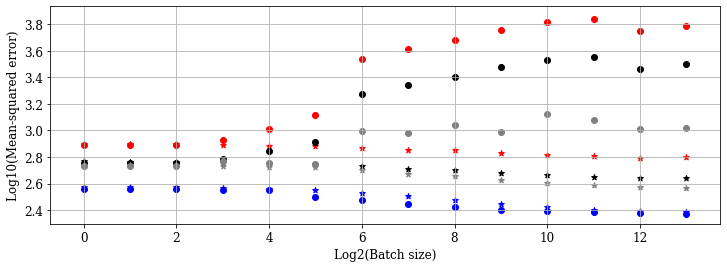

In [29]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.median(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.median(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

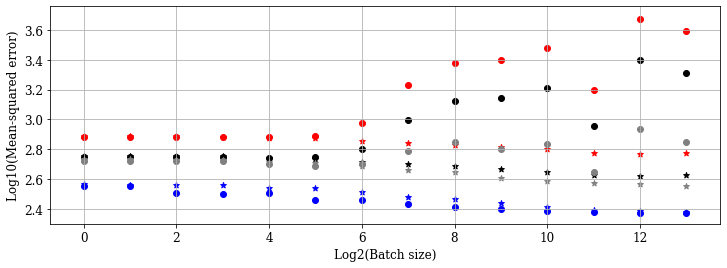

In [30]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.min(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.min(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

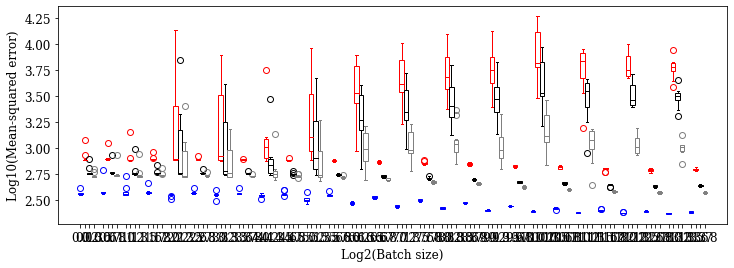

In [32]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        c = color_array[ikey]
        plt.boxplot(x = np.log10(BFval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+ikey/10])
        plt.boxplot(x = np.log10(CIval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+0.5+ikey/10])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(BFval)),label=key,color=color_array[ikey])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

In [40]:
np.log10(400)

2.6020599913279625

# Small data experiments using number of batches instead of batch size